### R,S 파악
    - p, r, s 계산 공식 포함..근데 p를 잘 잡아내는 것 같지는 않다. 예시는 잘 잡아낸거 같지만..

# 1) Denoising

In [10]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from scipy.fft import fft, fftfreq
from scipy.signal import firwin, lfilter, freqz, filtfilt

# import vitaldb
# import pyvital
import pyvital.arr as pv
# import pyvital.filters.abp_ppv as f

import wfdb

In [279]:
ECG_df['WaveForm'].iloc[0]['I']

NameError: name 'ECG_df' is not defined

In [12]:
lowcut = 5.0
highcut = 15.0
nyquist = 0.5 * 500
low = lowcut / nyquist
high = highcut / nyquist
b, a = scipy.signal.butter(1, [low, high], btype="band")
filtered_ecg = scipy.signal.filtfilt(b, a, ECG_df['WaveForm'].iloc[0]['I'])

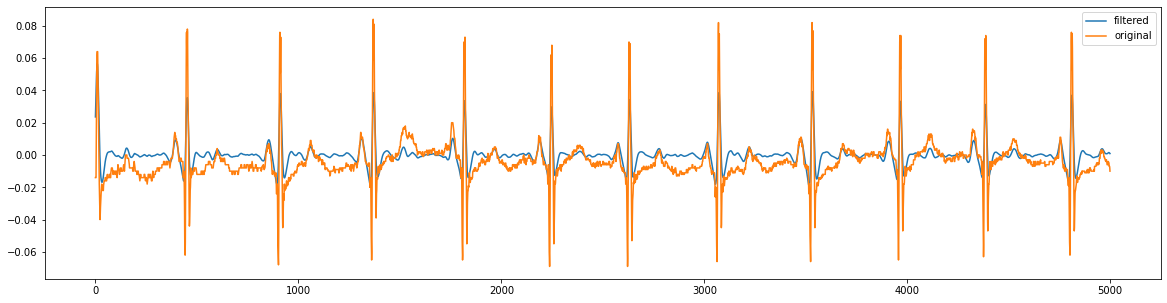

In [13]:
# 그래프 설정
plt.figure(figsize=(20, 5))
plt.plot(filtered_ecg,label = 'filtered')
plt.plot(ECG_df['WaveForm'].iloc[0]['I'],label = 'original')
plt.legend()

#### 2) Pan Tomkins 기반으로 R 찾아내고 찾아낸 R 기반으로 P랑 S 검출
- ex) s : R 이 발견되고 특정 시간 내로 발견된 가장 작은 값

In [37]:
ECG_df.columns

Index(['PatientID', 'PatientAge', 'Gender', 'AcquisitionDate',
       'VentricularRate', 'AtrialRate', 'PRInterval', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'QRSCount',
       'QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset', 'QTcFrederica',
       'GlobalRR', 'QTRGGR', 'WaveformStartTime', 'PharmaRRinterval',
       'PharmaPPinterval', 'WaveForm', 'Global_RR'],
      dtype='object')

In [41]:
ECG_df.AtrialRate.max()

'99'

In [40]:
ECG_df.AtrialRate.min()

'0'

In [123]:
import numpy as np
import scipy.signal

def pan_tompkins_detector(ecg_signal, fs, window_coe):
    # Bandpass filter
    lowcut = 10.0
    highcut = 20.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = scipy.signal.butter(1, [low, high], btype="band")
    filtered_ecg = scipy.signal.filtfilt(b, a, ecg_signal)

    # Derivative filter
    diff_ecg = np.diff(filtered_ecg)
    diff_ecg = np.append(diff_ecg, 0)
    squared_ecg = diff_ecg ** 2

    # Moving window integration
    window_size = int(window_coe * fs)
    mwa_ecg = np.convolve(squared_ecg, np.ones(window_size) / window_size, mode='same')

    # Peak detection
    min_heart_rate = 70  # 소아의 최소 심박수 (bpm)
    max_heart_rate = 150
      # 소아의 최대 심박수 (bpm)

    # 최소 및 최대 심박수에 따른 distance 값 설정
    min_distance = int((60 / max_heart_rate) * fs)  # 최대 심박수에 대한 최소 피크 거리
    max_distance = int((60 / min_heart_rate) * fs)  # 최소 심박수에 대한 최대 피크 거리
    distance = (min_distance + max_distance) // 2   # 평균값 사용

    peaks, _ = scipy.signal.find_peaks(mwa_ecg, distance=distance)

    return peaks

# 예시 사용법
# fs = 500
# window_coe = 0.15  # 이동 평균 창의 크기, 필요에 따라 조정
# ecg_signal = np.random.randn(5000)  # 가상의 ECG 신호
# peaks = pan_tompkins_detector(ecg_signal, fs, window_coe)
# print(peaks)


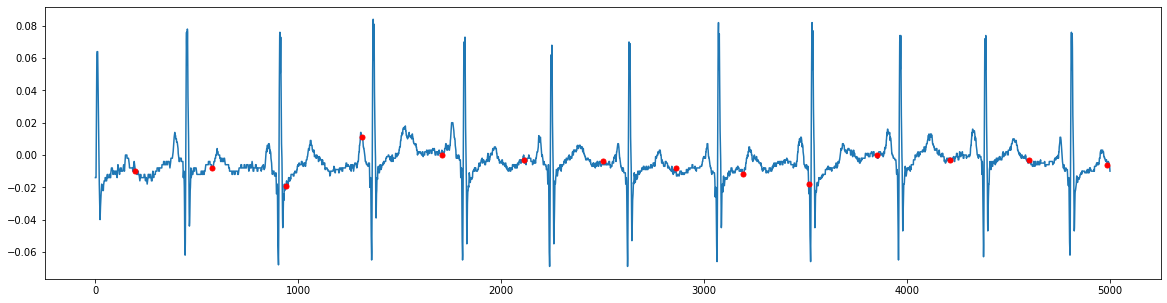

In [125]:
y = ECG_df['WaveForm'].iloc[0]['I']
red_dot_indices = pan_tompkins_detector(ECG_df['WaveForm'].iloc[2]['I'], 500, 0.05)
# 빨간 점을 찍을 y값
red_dot_y_values = [y[i-1] for i in red_dot_indices]  # i-1 because of zero-based indexing

# 그래프 설정
plt.figure(figsize=(20, 5))

# 라인 그래프 그리기
plt.plot(x, y, label='ECG Waveform')

# 특정 위치에 빨간 점 그리기
plt.plot(red_dot_indices, red_dot_y_values, 'ro', markersize=5)  # 'ro'는 빨간 점을 의미


In [139]:
ecg_signal = ECG_df['WaveForm'].iloc[0]['I']
# OPTION 1: very fast, good performance, large user-base
import neurokit2  # pip install neurokit2
_, results = neurokit2.ecg_peaks(ecg_signal, sampling_rate=500)
rpeaks = results["ECG_R_Peaks"]

<Figure size 1440x360 with 0 Axes>

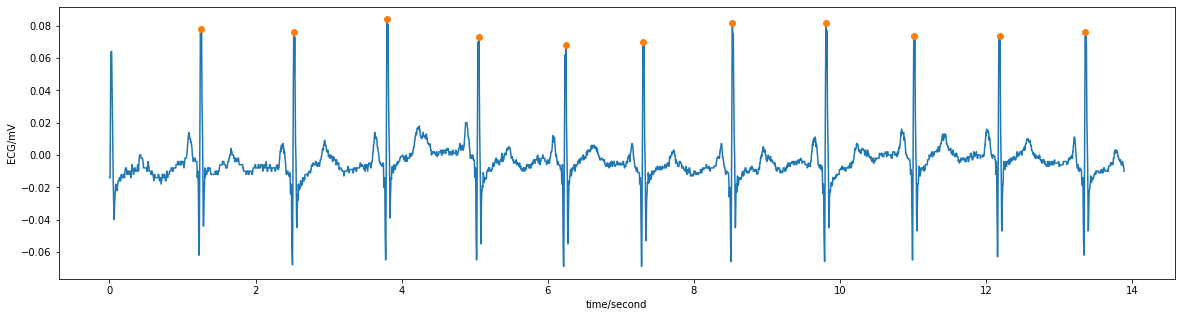

In [145]:
import wfdb  # pip install wfdb
plt.figure(figsize=(20, 5))

# less fancy: plt.plot(ecg_signal); plt.plot(rpeaks, ecg_signal[rpeaks], "x")
fig = wfdb.plot_items(
    ecg_signal,
    [rpeaks],
    fs=360,
    sig_name=["ECG"],
    sig_units=["mV"],
    time_units="seconds",
    return_fig=True,
    ann_style="o",
    figsize=(20,5),
)


In [17]:
def calculate_RRinterval(R_peaks):
    df_rr = pd.DataFrame(R_peaks, columns=['R_peaks'])
    df_rr['RR_interval'] = df_rr['R_peaks'].diff()

    return df_rr

R_peaks = pan_tompkins_detector(ECG_df['WaveForm'].iloc[0]['I'], 500, 0.05)
df_rr = calculate_RRinterval(R_peaks)
np.mean(df_rr['RR_interval'])

436.3636363636364

In [18]:
r_peaks = pan_tompkins_detector(ECG_df['WaveForm'].iloc[0]['I'], 500, 0.05)

In [19]:
# P 파 검출 함수
def detect_p_points(ecg_signal, r_peaks, fs):
    p_points = []
    for r in r_peaks:
        search_window = ecg_signal[int(r - 0.2 * fs):r]  # R 파 이전 200ms 구간 탐색
        if len(search_window) == 0:
            continue
        p_point = np.argmax(search_window) + int(r - 0.2 * fs)  # 최대값의 인덱스를 P 파로 선택
        p_points.append(p_point)
    return p_points

In [20]:
a = ECG_df['WaveForm'].iloc[0]['III']
np.mean(a[detect_p_points(ECG_df['WaveForm'].iloc[0]['I'],r_peaks, 500)])

-0.05236363636363637

In [21]:
detect_p_points(ECG_df['WaveForm'].iloc[0]['I'],r_peaks, 500)

[449, 909, 1368, 1816, 2245, 2629, 3070, 3531, 3964, 4383, 4809]

In [22]:
a[detect_p_points(ECG_df['WaveForm'].iloc[0]['I'],r_peaks, 500)]

array([-0.106, -0.081, -0.078, -0.062, -0.038, -0.03 , -0.045, -0.041,
       -0.042, -0.036, -0.017])

In [ ]:
y = ecg_signal
r_peaks

In [23]:
# final_df = pd.DataFrame({'R_Value':[], 'S_Value':[],'R/S_Ratio':[]})
r_value = []
s_value = []
r_s_ratio = []
for i in tqdm(range(len(ECG_df))):
    
    signal = ECG_df['WaveForm'].iloc[i]['I']

    # 예시 사용법
    fs = 500
    window_coe = 0.05  # 이동 평균 창의 크기, 필요에 따라 조정
    ecg_signal = signal
    x = [i for i in range(1, len(ecg_signal) + 1)]
    y = ecg_signal

    # R 파와 S 파 검출
    r_peaks = pan_tompkins_detector(ecg_signal, fs, window_coe)
    s_points = detect_s_points(ecg_signal, r_peaks, fs)

    # R 파와 S 파의 값 구하기
    r_values = [y[i-1] for i in r_peaks]  # i-1 because of zero-based indexing
    s_values = [y[i-1] for i in s_points]  # i-1 because of zero-based indexing

    # R/S 비율 계산
    rs_ratio = [r / s if s != 0 else np.nan for r, s in zip(r_values, s_values)]

    r_value.append(np.mean(r_values))
    s_value.append(np.mean(s_values))
    r_s_ratio.append(np.mean(rs_ratio))

    # # 데이터프레임 생성
    # df = pd.DataFrame({
    #     'R_Value': r_values,
    #     'S_Value': s_values,
    #     'R/S_Ratio': rs_ratio
    # })

    # final_df = pd.concat((final_df,df))


ECG_df['R'] = r_value
ECG_df['S'] = s_value
ECG_df['R/S Ratio'] = r_s_ratio

  0%|          | 0/4660 [00:00<?, ?it/s]


NameError: name 'detect_s_points' is not defined

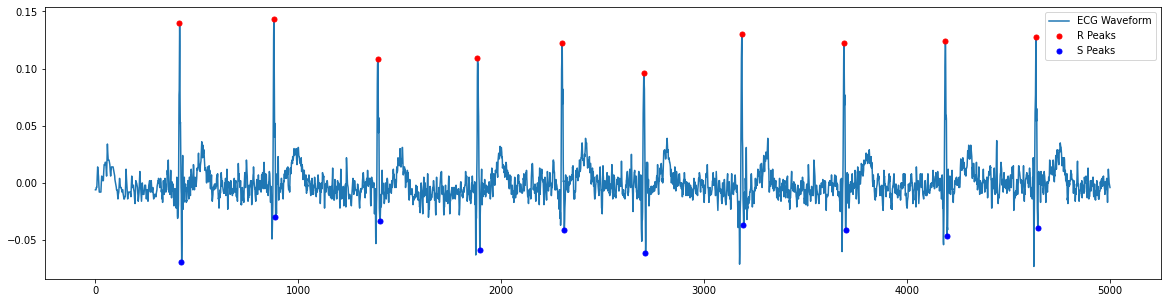

In [148]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
import neurokit2  # pip install neurokit2


# Pan-Tompkins 알고리즘
def pan_tompkins_detector(ecg_signal):
    # Bandpass filter
    # lowcut = 5.0
    # highcut = 15.0
    # nyquist = 0.5 * fs
    # low = lowcut / nyquist
    # high = highcut / nyquist
    # b, a = scipy.signal.butter(1, [low, high], btype="band")
    # filtered_ecg = scipy.signal.filtfilt(b, a, ecg_signal)

    # # Derivative filter
    # diff_ecg = np.diff(filtered_ecg)
    # squared_ecg = diff_ecg ** 2

    # # Moving window integration
    # window_size = int(window_coe * fs)
    # mwa_ecg = np.convolve(squared_ecg, np.ones(window_size) / window_size, mode='same')

    # # Peak detection
    # min_heart_rate = 70  # 소아의 최소 심박수 (bpm)
    # max_heart_rate = 120  # 소아의 최대 심박수 (bpm)

    # # 최소 및 최대 심박수에 따른 distance 값 설정
    # min_distance = int((60 / max_heart_rate) * fs)  # 최대 심박수에 대한 최소 피크 거리
    # max_distance = int((60 / min_heart_rate) * fs)  # 최소 심박수에 대한 최대 피크 거리
    # distance = (min_distance + max_distance) // 2   # 평균값 사용

    # peaks, _ = scipy.signal.find_peaks(mwa_ecg, distance=distance)

    # return peaks
    _, results = neurokit2.ecg_peaks(ecg_signal, sampling_rate=500)
    rpeaks = results["ECG_R_Peaks"]

    return rpeaks

# # P 파 검출 함수 (개선된 버전)
# def detect_p_points(ecg_signal, r_peaks, fs):
#     p_points = []
#     for r in r_peaks:
#         search_window_start = max(0, int(r - 0.3 * fs))  # R 파 이전 300ms 구간 탐색
#         search_window_end = r - int(0.1 * fs)  # R 파 직전 100ms 까지의 구간 탐색
#         search_window = ecg_signal[search_window_start:search_window_end]
#         if len(search_window) == 0:
#             continue
#         baseline = np.mean(search_window)  # baseline을 기준으로 peak 검출
#         search_window -= baseline  # baseline 조정
#         p_point = np.argmax(search_window) + search_window_start  # 최대값의 인덱스를 P 파로 선택
#         if ecg_signal[p_point] < ecg_signal[r]:  # P 피크 값이 R 피크 값보다 작은 경우만 추가
#             p_points.append(p_point)
#     return p_points

# S 파 검출 함수
def detect_s_points(ecg_signal, r_peaks, fs):
    s_points = []
    for r in r_peaks:
        search_window = ecg_signal[r:min(len(ecg_signal), int(r + 0.1 * fs))]  # R 파 이후 100ms 구간 탐색
        if len(search_window) == 0:
            continue
        s_point = np.argmin(search_window) + r  # 최소값의 인덱스를 S 파로 선택
        s_points.append(s_point)
    return s_points

# PR interval 계산 함수
# def calculate_pr_interval(p_peaks, r_peaks, fs):
#     pr_intervals = []
#     for r in r_peaks:
#         p_before_r = [p for p in p_peaks if p < r]
#         if p_before_r:
#             p = p_before_r[-1]  # R 파 직전의 마지막 P 파 선택
#             pr_interval = (r - p) / fs  # 시간 간격 계산 (초 단위)
#             pr_intervals.append(pr_interval)
#     return pr_intervals

# 예시 사용법
fs = 500  # 샘플링 주파수 (Hz)
window_coe = 0.05  # 이동 평균 창의 크기, 필요에 따라 조정
ecg_signal = ECG_df['WaveForm'].iloc[1]['I']
x = [i for i in range(1, len(ecg_signal) + 1)]
y = ecg_signal

# R 파와 S 파 검출
r_peaks = pan_tompkins_detector(ecg_signal)
s_points = detect_s_points(ecg_signal, r_peaks, fs)
# p_peaks = detect_p_points(ecg_signal, r_peaks, fs)

# PR interval 계산
# pr_intervals = calculate_pr_interval(p_peaks, r_peaks, fs)

# R, S, P 값 구하기
r_values = [y[i] for i in r_peaks]  # R 값
s_values = [y[i] for i in s_points]  # S 값
# p_values = [y[i] for i in p_peaks]  # P 값

# R/S 비율 계산
rs_ratio = [r / s if s != 0 else np.nan for r, s in zip(r_values, s_values)]

# 데이터프레임 생성
# df = pd.DataFrame({
#     'R_Peak': r_peaks,
#     'R_Value': r_values,
#     'S_Peak': s_points,
#     'S_Value': s_values,
#     'P_Peak': p_peaks,
#     'P_Value': p_values,
#     'R/S_Ratio': rs_ratio,
#     'PR_Interval': pr_intervals
# })

# # NaN 값을 포함하는 행 필터링
# nan_rows = df[df.isna().any(axis=1)]

# # import ace_tools as tools; tools.display_dataframe_to_user(name="NaN Rows DataFrame", dataframe=nan_rows)

# # 결과 출력
# print("DataFrame with NaN values:")
# print(nan_rows)

# 그래프 설정
plt.figure(figsize=(20, 5))

# 라인 그래프 그리기
plt.plot(x, y, label='ECG Waveform')

# R 파 위치에 빨간 점 그리기
plt.plot(r_peaks, [y[i] for i in r_peaks], 'ro', markersize=5, label='R Peaks')

# S 파 위치에 파란 점 그리기
plt.plot(s_points, [y[i] for i in s_points], 'bo', markersize=5, label='S Peaks')

# P 파 위치에 녹색 점 그리기
# plt.plot(p_peaks, [y[i] for i in p_peaks], 'go', markersize=5, label='P Peaks')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()


### Q 포함

In [299]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import neurokit2

# Pan-Tompkins 알고리즘
def pan_tompkins_detector(ecg_signal):
    # Bandpass filter
    _, results = neurokit2.ecg_peaks(ecg_signal, sampling_rate=500)
    rpeaks = results["ECG_R_Peaks"]

    return rpeaks

# S 파 검출 함수
def detect_s_points(ecg_signal, r_peaks, fs):
    s_points = []
    for r in r_peaks:
        search_window = ecg_signal[r:int(r + 0.1 * fs)]  # R 파 이후 100ms 구간 탐색
        if len(search_window) == 0:
            continue
        s_point = np.argmin(search_window) + r  # 최소값의 인덱스를 S 파로 선택
        s_points.append(s_point)
    return s_points

# Q 파 검출 함수
def detect_q_points(ecg_signal, r_peaks, fs):
    q_points = []
    for r in r_peaks:
        search_window = ecg_signal[int(r - 0.1 * fs):r]  # R 파 이전 100ms 구간 탐색
        if len(search_window) == 0:
            continue
        q_point = np.argmin(search_window) + (r - len(search_window))  # 최소값의 인덱스를 Q 파로 선택
        q_points.append(q_point)
    return q_points

# R, S, Q 값 계산 및 데이터프레임 업데이트
r_value = []
s_value = []
q_value = []
r_s_ratio = []
q_r_ratio = []
fs = 500
ecg_signal = final_data.iloc[0]['WaveForm']['V4']
x = [i for i in range(1, len(ecg_signal) + 1)]
y = ecg_signal
try:
    # R 파, S 파, Q 파 검출
    r_peaks = pan_tompkins_detector(ecg_signal)
    s_points = detect_s_points(ecg_signal, r_peaks, fs)
    q_points = detect_q_points(ecg_signal, r_peaks, fs)

    # R, S, Q 값 구하기
    r_values = [y[i-1] for i in r_peaks]  # i-1 because of zero-based indexing
    s_values = [y[i-1] for i in s_points]  # i-1 because of zero-based indexing
    q_values = [y[i-1] for i in q_points]  # i-1 because of zero-based indexing

    # R/S 비율 계산
    rs_ratio = [r / s if s != 0 else np.nan for r, s in zip(r_values, s_values)]
    # Q/R 비율 계산
    qr_ratio = [q / r if r != 0 else np.nan for q, r in zip(q_values, r_values)]

    # 평균값 계산 및 리스트에 추가
    r_value.append(np.mean(r_values))
    s_value.append(np.mean(s_values))
    q_value.append(np.mean(q_values))

    r_s_ratio.append(np.mean(rs_ratio))
    q_r_ratio.append(np.mean(qr_ratio))
except:
    r_value.append(np.nan)
    s_value.append(np.nan)
    q_value.append(np.nan)

    r_s_ratio.append(np.nan)
    q_r_ratio.append(np.nan)

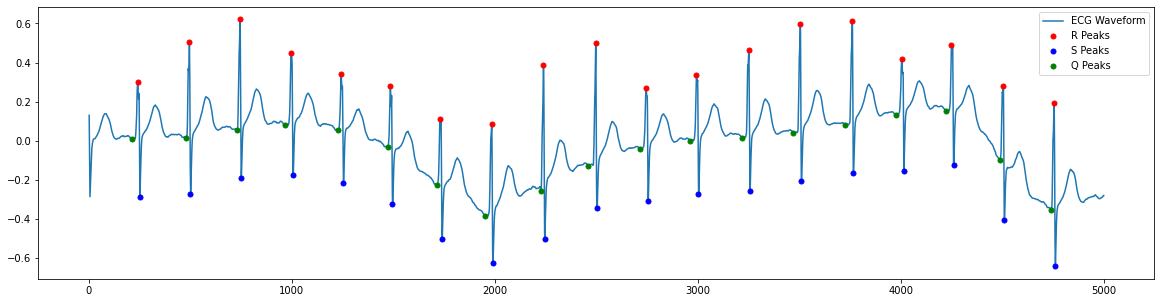

In [302]:
plt.figure(figsize=(20, 5))

# 라인 그래프 그리기
plt.plot(x, y, label='ECG Waveform')

# R 파 위치에 빨간 점 그리기
plt.plot(r_peaks, [y[i] for i in r_peaks], 'ro', markersize=5, label='R Peaks')

# S 파 위치에 파란 점 그리기
plt.plot(s_points, [y[i] for i in s_points], 'bo', markersize=5, label='S Peaks')

# P 파 위치에 녹색 점 그리기
plt.plot(q_points, [y[i] for i in q_points], 'go', markersize=5, label='Q Peaks')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()

#### QRS Complex 추출

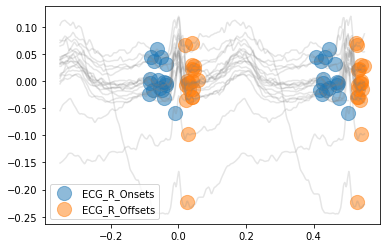

In [178]:
_,rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate = 500)
a,b = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate = 500, method = 'dwt', show = True, show_type = 'bounds_R')
x = [i for i in range(1, len(ecg_signal) + 1)]
y = ecg_signal

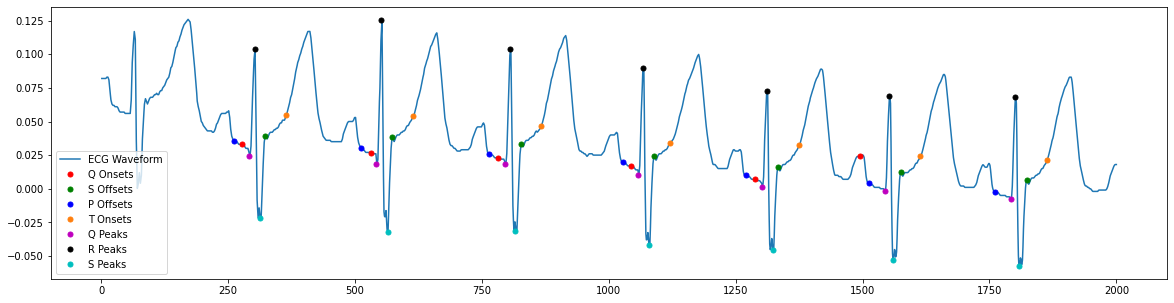

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

# ECG 신호 설정
ecg_signal = final_data.iloc[2]['WaveForm']['I'][:2000]
x = [i for i in range(1, len(ecg_signal) + 1)]
y = ecg_signal

# Pan-Tompkins 알고리즘 (R 파 검출)
def pan_tompkins_detector(ecg_signal):
    _, results = nk.ecg_peaks(ecg_signal, sampling_rate=500)
    rpeaks = results["ECG_R_Peaks"]
    return rpeaks

# S 파 검출 함수
def detect_s_points(ecg_signal, r_peaks, fs):
    s_points = []
    for r in r_peaks:
        search_window = ecg_signal[r:int(r + 0.1 * fs)]  # R 파 이후 100ms 구간 탐색
        if len(search_window) == 0:
            continue
        s_point = np.argmin(search_window) + r  # 최소값의 인덱스를 S 파로 선택
        s_points.append(s_point)
    return s_points

# Q 파 검출 함수
def detect_q_points(ecg_signal, r_peaks, fs):
    q_points = []
    for r in r_peaks:
        search_window = ecg_signal[int(r - 0.1 * fs):r]  # R 파 이전 100ms 구간 탐색
        if len(search_window) == 0:
            continue
        q_point = np.argmin(search_window) + (r - len(search_window))  # 최소값의 인덱스를 Q 파로 선택
        q_points.append(q_point)
    return q_points


fs = 500

# ECG 신호 처리
signals, info = nk.ecg_process(ecg_signal, sampling_rate=500)

# R onset, R offset, P offset 추출 및 NaN 값 제거
R_onsets = info['ECG_R_Onsets']
R_onsets = [int(x) for x in R_onsets if not np.isnan(x)]

R_offsets = info['ECG_R_Offsets']
R_offsets = [int(x) for x in R_offsets if not np.isnan(x)]

P_offsets = info['ECG_P_Offsets']
P_offsets = [int(x) for x in P_offsets if not np.isnan(x)]

T_onsets = info['ECG_T_Onsets']
T_onsets = [int(x) for x in T_onsets if not np.isnan(x)]

# Pan-Tompkins 알고리즘을 사용한 R 파 검출
r_peaks = pan_tompkins_detector(ecg_signal)

# Q 파와 S 파 검출
q_points = detect_q_points(ecg_signal, r_peaks, fs)
s_points = detect_s_points(ecg_signal, r_peaks, fs)

# 그래프 설정
plt.figure(figsize=(20, 5))

# ECG 파형 그리기
plt.plot(x, y, label='ECG Waveform')

# R onset 위치에 빨간 점 그리기
plt.plot(R_onsets, [y[i] for i in R_onsets], 'ro', markersize=5, label='Q Onsets')

# R offset 위치에 초록 점 그리기
plt.plot(R_offsets, [y[i] for i in R_offsets], 'go', markersize=5, label='S Offsets')

# P offset 위치에 파란 점 그리기
plt.plot(P_offsets, [y[i] for i in P_offsets], 'bo', markersize=5, label='P Offsets')

# P offset 위치에 파란 점 그리기
plt.plot(T_onsets, [y[i] for i in T_onsets], 'o', markersize=5, label='T Onsets')

# Q 파 위치에 녹색 점 그리기
plt.plot(q_points, [y[i] for i in q_points], 'mo', markersize=5, label='Q Peaks')

# R 파 위치에 검은 점 그리기
plt.plot(r_peaks, [y[i] for i in r_peaks], 'ko', markersize=5, label='R Peaks')

# S 파 위치에 보라색 점 그리기
plt.plot(s_points, [y[i] for i in s_points], 'co', markersize=5, label='S Peaks')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()


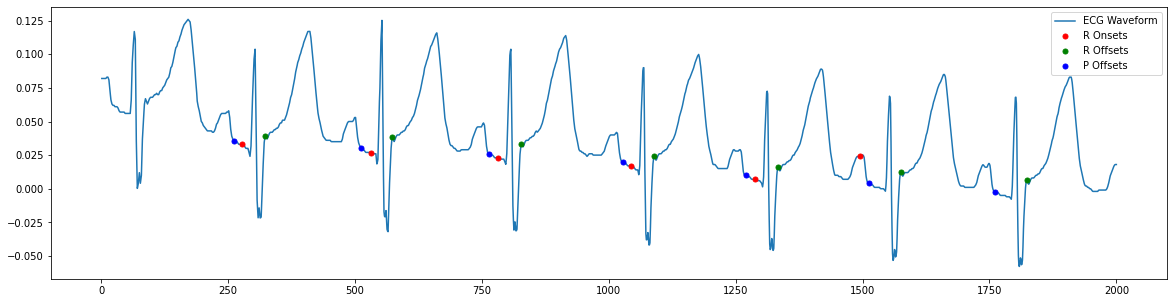

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

# ECG 신호 설정
ecg_signal = final_data['WaveForm'].iloc[2]['I'][:2000]
x = [i for i in range(1, len(ecg_signal) + 1)]
y = ecg_signal

# ECG 신호 처리
signals, info = nk.ecg_process(ecg_signal, sampling_rate=500)

# R onset, R offset, P offset 추출 및 NaN 값 제거
R_onsets = info['ECG_R_Onsets']
R_onsets = [int(x) for x in R_onsets if not np.isnan(x)]

R_offsets = info['ECG_R_Offsets']
R_offsets = [int(x) for x in R_offsets if not np.isnan(x)]

P_offsets = info['ECG_P_Offsets']
P_offsets = [int(x) for x in P_offsets if not np.isnan(x)]

# 그래프 설정
plt.figure(figsize=(20, 5))

# ECG 파형 그리기
plt.plot(x, y, label='ECG Waveform')

# R onset 위치에 빨간 점 그리기
plt.plot(R_onsets, [y[i] for i in R_onsets], 'ro', markersize=5, label='R Onsets')

# R offset 위치에 초록 점 그리기
plt.plot(R_offsets, [y[i] for i in R_offsets], 'go', markersize=5, label='R Offsets')

# P offset 위치에 파란 점 그리기
plt.plot(P_offsets, [y[i] for i in P_offsets], 'bo', markersize=5, label='P Offsets')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()


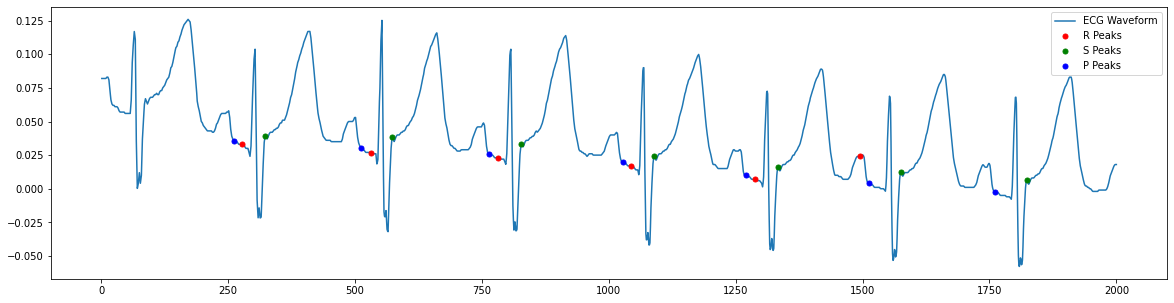

In [146]:
import neurokit2 as nk
ecg_signal = final_data['WaveForm'].iloc[2]['I'][:2000]
x = [i for i in range(1, len(ecg_signal) + 1)]
y = ecg_signal

# ECG 신호 처리
signals, info = nk.ecg_process(ecg_signal, sampling_rate=500)
R_onsets = info['ECG_R_Onsets']ㅁ
R_onsets = [x for x in R_onsets if ~np.isnan(x)]
R_offsets = info['ECG_R_Offsets']
R_offsets = [x for x in R_offsets if ~np.isnan(x)]
P_offsets = info['ECG_P_Offsets']
P_offsets = [x for x in P_offsets if ~np.isnan(x)]

# 그래프 설정
plt.figure(figsize=(20, 5))

# 라인 그래프 그리기
plt.plot(x, y, label='ECG Waveform')

# R 파 위치에 빨간 점 그리기
plt.plot(R_onsets, [y[i] for i in R_onsets], 'ro', markersize=5, label='R Peaks')

# S 파 위치에 파란 점 그리기
plt.plot(R_offsets, [y[i] for i in R_offsets], 'go', markersize=5, label='S Peaks')

# S 파 위치에 파란 점 그리기
plt.plot(P_offsets, [y[i] for i in P_offsets], 'bo', markersize=5, label='P Peaks')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()

In [134]:
import numpy as np
import neurokit2

# Pan-Tompkins 알고리즘 (R 파 검출)
def pan_tompkins_detector(ecg_signal):
    _, results = neurokit2.ecg_peaks(ecg_signal, sampling_rate=500)
    rpeaks = results["ECG_R_Peaks"]
    return rpeaks

# S 파 검출 함수
def detect_s_points(ecg_signal, r_peaks, fs):
    s_points = []
    for r in r_peaks:
        search_window = ecg_signal[r:int(r + 0.1 * fs)]  # R 파 이후 100ms 구간 탐색
        if len(search_window) == 0:
            continue
        s_point = np.argmin(search_window) + r  # 최소값의 인덱스를 S 파로 선택
        s_points.append(s_point)
    return s_points

# Q 파 검출 함수
def detect_q_points(ecg_signal, r_peaks, fs):
    q_points = []
    for r in r_peaks:
        search_window = ecg_signal[int(r - 0.1 * fs):r]  # R 파 이전 100ms 구간 탐색
        if len(search_window) == 0:
            continue
        q_point = np.argmin(search_window) + (r - len(search_window))  # 최소값의 인덱스를 Q 파로 선택
        q_points.append(q_point)
    return q_points

# R onset 검출 함수
def detect_r_onset(ecg_signal, r_peaks, fs):
    r_onsets = []
    for r in r_peaks:
        search_window = ecg_signal[int(r - 0.05 * fs):r]  # R 파 이전 50ms 구간 탐색
        if len(search_window) == 0:
            continue
        r_onset = np.argmax(np.diff(search_window)) + (r - len(search_window))  # 신호 기울기의 최대값을 R onset으로 선택
        r_onsets.append(r_onset)
    return r_onsets

# R offset 검출 함수
def detect_r_offset(ecg_signal, r_peaks, fs):
    r_offsets = []
    for r in r_peaks:
        search_window = ecg_signal[r:int(r + 0.05 * fs)]  # R 파 이후 50ms 구간 탐색
        if len(search_window) == 0:
            continue
        r_offset = np.argmax(np.diff(search_window)) + r  # 신호 기울기의 최대값을 R offset으로 선택
        r_offsets.append(r_offset)
    return r_offsets

# R, S, Q 값 계산 및 데이터프레임 업데이트
r_value = []
s_value = []
q_value = []
r_s_ratio = []
q_r_ratio = []
r_onset_value = []
r_offset_value = []

fs = 500
ecg_signal = final_data.iloc[0]['WaveForm']['V4']
x = [i for i in range(1, len(ecg_signal) + 1)]
y = ecg_signal

try:
    # R 파, S 파, Q 파, R onset, R offset 검출
    r_peaks = pan_tompkins_detector(ecg_signal)
    s_points = detect_s_points(ecg_signal, r_peaks, fs)
    q_points = detect_q_points(ecg_signal, r_peaks, fs)
    r_onsets = detect_r_onset(ecg_signal, r_peaks, fs)
    r_offsets = detect_r_offset(ecg_signal, r_peaks, fs)

    # R, S, Q 값 구하기
    r_values = [y[i-1] for i in r_peaks]  # i-1 because of zero-based indexing
    s_values = [y[i-1] for i in s_points]  # i-1 because of zero-based indexing
    q_values = [y[i-1] for i in q_points]  # i-1 because of zero-based indexing

    # R onset, R offset 값 구하기
    r_onset_values = [y[i-1] for i in r_onsets]
    r_offset_values = [y[i-1] for i in r_offsets]

    # R/S 비율 계산
    rs_ratio = [r / s if s != 0 else np.nan for r, s in zip(r_values, s_values)]
    # Q/R 비율 계산
    qr_ratio = [q / r if r != 0 else np.nan for q, r in zip(q_values, r_values)]

    # 평균값 계산 및 리스트에 추가
    r_value.append(np.mean(r_values))
    s_value.append(np.mean(s_values))
    q_value.append(np.mean(q_values))

    r_onset_value.append(np.mean(r_onset_values))
    r_offset_value.append(np.mean(r_offset_values))

    r_s_ratio.append(np.mean(rs_ratio))
    q_r_ratio.append(np.mean(qr_ratio))

except:
    r_value.append(np.nan)
    s_value.append(np.nan)
    q_value.append(np.nan)
    r_onset_value.append(np.nan)
    r_offset_value.append(np.nan)

    r_s_ratio.append(np.nan)
    q_r_ratio.append(np.nan)


---

In [121]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import neurokit2

# Pan-Tompkins 알고리즘
def pan_tompkins_detector(ecg_signal):
    # Bandpass filter
    _, results = neurokit2.ecg_peaks(ecg_signal, sampling_rate=500)
    rpeaks = results["ECG_R_Peaks"]

    return rpeaks

# S 파 검출 함수
def detect_s_points(ecg_signal, r_peaks, fs):
    s_points = []
    for r in r_peaks:
        search_window = ecg_signal[r:int(r + 0.1 * fs)]  # R 파 이후 100ms 구간 탐색
        if len(search_window) == 0:
            continue
        s_point = np.argmin(search_window) + r  # 최소값의 인덱스를 S 파로 선택
        s_points.append(s_point)
    return s_points

# Q 파 검출 함수
def detect_q_points(ecg_signal, r_peaks, fs):
    q_points = []
    for r in r_peaks:
        search_window = ecg_signal[int(r - 0.1 * fs):r]  # R 파 이전 100ms 구간 탐색
        if len(search_window) == 0:
            continue
        q_point = np.argmin(search_window) + (r - len(search_window))  # 최소값의 인덱스를 Q 파로 선택
        q_points.append(q_point)
    return q_points

# R, S, Q 값 계산 및 데이터프레임 업데이트


ECG_df = final_data
for j in ['I','V4','V5','V6']:
    r_value = []
    s_value = []
    q_value = []
    r_s_ratio = []
    q_r_ratio = []
    for i in tqdm(range(len(ECG_df))):
        signal = ECG_df['WaveForm'].iloc[i][j]
        fs = 500
        ecg_signal = signal
        y = ecg_signal
        try:
            # R 파, S 파, Q 파 검출
            r_peaks = pan_tompkins_detector(ecg_signal)
            s_points = detect_s_points(ecg_signal, r_peaks, fs)
            q_points = detect_q_points(ecg_signal, r_peaks, fs)

            # R, S, Q 값 구하기
            r_values = [y[i-1] for i in r_peaks]  # i-1 because of zero-based indexing
            s_values = [y[i-1] for i in s_points]  # i-1 because of zero-based indexing
            q_values = [y[i-1] for i in q_points]  # i-1 because of zero-based indexing

            # R/S 비율 계산
            rs_ratio = [r / s if s != 0 else np.nan for r, s in zip(r_values, s_values)]
            # Q/R 비율 계산
            qr_ratio = [q / r if r != 0 else np.nan for q, r in zip(q_values, r_values)]

            # 평균값 계산 및 리스트에 추가
            r_value.append(np.mean(r_values))
            s_value.append(np.mean(s_values))
            q_value.append(np.mean(q_values))

            r_s_ratio.append(np.mean(rs_ratio))
            q_r_ratio.append(np.mean(qr_ratio))
        except:
            r_value.append(np.nan)
            s_value.append(np.nan)
            q_value.append(np.nan)

            r_s_ratio.append(np.nan)
            q_r_ratio.append(np.nan)

    # 데이터프레임 업데이트
    ECG_df['R_'+j] = r_value
    ECG_df['S_'+j] = s_value
    ECG_df['Q_'+j] = q_value
    ECG_df['R/S Ratio_'+j] = r_s_ratio
    


100%|████████████████████████████████| 4427/4427 [00:06<00:00, 705.67it/s]


ValueError: Length of values (4428) does not match length of index (4427)

### ECG 정보 로드

In [67]:
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm
import numpy as np


file_dir = pd.read_csv('ECG_files.csv')
file_lst = file_dir['file_path'].tolist()

def parse_xml_to_df(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # 모든 데이터 저장용 리스트
    all_data = []

    # XML 파일의 각 항목 반복
    for item in root.findall('./*'):
        # 항목 데이터를 딕셔너리로 저장
        item_data = {}
        for child in item:
            item_data[child.tag] = child.text
        all_data.append(item_data)

    # DataFrame으로 변환
    df = pd.DataFrame(all_data)


    import array
    import base64
    waveforms = tree.findall('./Waveform')
    waveform = waveforms[1] # waveformtype : rhythm
    samplingrate = waveform.find('SampleBase').text
    waveformleaddata = waveform.findall('./LeadData')

    leads = []
    waveformdata = []
    for sub_leaddata in waveformleaddata:
        lead = sub_leaddata.find('LeadID').text
        leads.append(lead)
        
        lead_data = sub_leaddata.find('WaveFormData').text
        lead_data = lead_data.encode('ISO-8859-1')
        data_b64  = base64.b64decode(lead_data)
        # data_vals = np.asarray(data_b64)
        data_vals = np.array(array.array('h', data_b64))
        data_vals = data_vals / 1000 # microvolt -> millivort convert
        waveformdata.append(data_vals)

    leads_data = dict()
    for idx, lead in enumerate(leads):
        leads_data[lead] = waveformdata[idx]

    # 나머지 4개 leads 만들기
    # -aVR = (I + II) / 2 aVL = (I - III) / 2 aVF = (II + III) / 2
    I = leads_data['I']
    II = leads_data['II']
    III = leads_data['II'] - leads_data['I']

    aVR = (I + II) / 2
    aVL = (I - III) / 2
    aVF = (II + III) / 2

    leads_data['III'] = III
    leads_data['aVR'] = aVR
    leads_data['aVL'] = aVL
    leads_data['aVF'] = aVF


    return df, leads_data

ecg_statistic_list = ['PatientID', 'PatientAge', 'Gender', 'AcquisitionDate',
       'VentricularRate', 'AtrialRate',
        'PRInterval', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'QRSCount',
       'QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset', 
       'QTcFrederica', 
        'GlobalRR', 'QTRGGR',
       'WaveformStartTime',
       'PharmaRRinterval', 'PharmaPPinterval','WaveForm']
#'QRS', 'TIPIStatementCodes''TIPIScore',
ECG_df = pd.DataFrame(columns = ecg_statistic_list)
for i in tqdm(file_lst):
    # XML 파일 경로
    # xml_file = '/ExtendedCDM/ECG/ECG_xml/ECG_xml_CHILD/2018/2451668_20180807_0921.xml'
    xml_file = i
    df,lead_data = parse_xml_to_df(xml_file)
    dff = pd.DataFrame(columns = ecg_statistic_list)
    for j in ecg_statistic_list:
        try:
            if len(df[j].unique())>=2 :
                dff[j] = [df[j].unique()[1]]
            elif len(df[j].unique()) < 2:
                dff[j] = [df[j].unique()[0]]
        except:
            dff[j] = ['NaN']
    dff['WaveForm'] = [lead_data]
    ECG_df = pd.concat([ECG_df,dff], axis=0)


global_RR = []
for i in tqdm(file_lst):
    xml_file = i
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for i in tree.findall('./QRSTimesTypes/GlobalRR'):
        global_RR.append(i.text)
ECG_df['Global_RR'] = global_RR

ECG_df['AcquisitionDate'] = pd.to_datetime(ECG_df['AcquisitionDate'])

# type 변경
ECG_df['PatientID'] = ECG_df['PatientID'].astype('int')
ECG_df['AcquisitionDate'] = pd.to_datetime(ECG_df['AcquisitionDate'], errors='coerce')
ECG_df['AcquisitionDate'] = ECG_df['AcquisitionDate'].dt.date

100%|██████████| 4660/4660 [00:04<00:00, 1138.79it/s]


In [97]:
ECG_df

,PatientID,PatientAge,Gender,AcquisitionDate,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,...,POffset,TOffset,QTcFrederica,GlobalRR,QTRGGR,WaveformStartTime,PharmaRRinterval,PharmaPPinterval,WaveForm,Global_RR
0,2234619,21,MALE,2018-07-10,69,69,116,88,384,411,...,205,416,402,871,248,0,869,869,"{'I': [-0.014, -0.014, -0.014, -0.014, 0.005, ...",871
0,2451668,16,MALE,2018-08-07,64,64,112,80,368,379,...,200,412,375,937,248,0,937,937,"{'I': [-0.006, -0.006, -0.006, -0.006, -0.004,...",937
0,2241815,23,MALE,2018-10-17,82,82,126,88,342,399,...,190,382,379,733,248,0,731,731,"{'I': [-0.002, -0.002, -0.002, -0.002, -0.004,...",733
0,2230765,17,MALE,2018-07-24,70,71,NaN,84,356,384,...,181,395,374,851,248,0,857,845,"{'I': [0.006, 0.006, 0.006, 0.006, 0.005, 0.00...",851
0,2416461,8,MALE,2018-06-04,82,82,124,88,344,401,...,204,390,381,735,248,0,731,731,"{'I': [0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002...",735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2172946,27,MALE,2011-01-19,100,100,150,104,370,477,...,204,410,NaN,600,248,0,NaN,NaN,"{'I': [-0.011, -0.011, -0.011, -0.011, -0.012,...",600
0,2172946,24,MALE,2011-01-18,111,111,124,100,318,432,...,231,405,NaN,537,248,0,NaN,NaN,"{'I': [-0.018, -0.018, -0.018, -0.018, -0.017,...",537
0,2230554,15,MALE,2011-02-21,74,74,132,106,372,413,...,215,413,NaN,813,248,0,812,810,"{'I': [-0.002, -0.002, -0.002, -0.002, -0.004,...",813
0,2172946,24,MALE,2011-01-16,96,96,132,110,354,447,...,228,422,NaN,623,248,0,NaN,NaN,"{'I': [0.026, 0.026, 0.026, 0.026, 0.023, 0.02...",623


In [98]:
ECG_df.columns

Index(['PatientID', 'PatientAge', 'Gender', 'AcquisitionDate',
       'VentricularRate', 'AtrialRate', 'PRInterval', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'QRSCount',
       'QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset', 'QTcFrederica',
       'GlobalRR', 'QTRGGR', 'WaveformStartTime', 'PharmaRRinterval',
       'PharmaPPinterval', 'WaveForm', 'Global_RR'],
      dtype='object')

### 라벨 정보 로드

In [99]:
person_progress = pd.read_excel('DMD_outcome_data.xlsx')[['person_id','ID','Death','CMP','HF Hosp','BirthD','Last_fu_date','Death date','initial Echo','last echo',' 50≤EF<55','40≤EF<50','30≤EF<40','<30','CMP_date','Hosp_date']]
for i in person_progress.columns[5:-1]:
    person_progress[i] = pd.to_datetime(person_progress[i], errors='coerce')
    person_progress[i] = person_progress[i].dt.date
person_progress.rename(columns={'person_id':'PatientID'}, inplace=True)
person_progress['PatientID'] = person_progress['PatientID'].astype('int')

/tmp/ipykernel_4128562/1830127791.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  person_progress = pd.read_excel('DMD_outcome_data.xlsx')[['person_id','ID','Death','CMP','HF Hosp','BirthD','Last_fu_date','Death date','initial Echo','last echo',' 50≤EF<55','40≤EF<50','30≤EF<40','<30','CMP_date','Hosp_date']]


In [100]:
person_progress['Hosp_date'].value_counts()
person_progress['Hosp_date'] = pd.to_datetime(person_progress['Hosp_date'], errors='coerce')
# 각 셀을 개별적으로 처리하여 날짜 형식으로 변환 가능하면 변환, 불가능하면 원래 문자열 유지
def convert_to_datetime(val):
    try:
        return pd.to_datetime(val, errors='raise')
    except (ValueError, TypeError):
        return val

person_progress['Hosp_date'] = person_progress['Hosp_date'].apply(convert_to_datetime)

### ECG 없는 환자 제외(17)

In [101]:
no_ecg_members = [i for i in person_progress['PatientID'].unique().tolist() if i not in ECG_df['PatientID'].unique().tolist()]
no_ecg_members

[2190956,
 2210964,
 2240112,
 2240700,
 2241571,
 2251904,
 2271611,
 2312228,
 2421718,
 2493112,
 2578515,
 2648486,
 2665188,
 2691074,
 2729049,
 2721556,
 3555418]

In [102]:
person_progress = person_progress[~person_progress['PatientID'].isin(no_ecg_members)]

### 라벨 정보와 ecg 정보 합치기

In [103]:
# 라벨 정보와 ecg 정보 합치기
merge_df = pd.merge(ECG_df,person_progress, on='PatientID',how='right')
merge_df

,PatientID,PatientAge,Gender,AcquisitionDate,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,...,Last_fu_date,Death date,initial Echo,last echo,50≤EF<55,40≤EF<50,30≤EF<40,<30,CMP_date,Hosp_date
0,94378,60,MALE,2011-05-04,88,88,152,104,358,433,...,2023-04-04,NaT,2011-05-27,2011-06-27,NaT,NaT,NaT,NaT,NaT,NaT
1,617500,36,MALE,2011-12-06,60,60,128,92,430,430,...,2023-03-22,NaT,2006-08-10,2023-03-22,2006-08-10,NaT,NaT,NaT,2006-08-10,NaT
2,617500,46,MALE,2021-05-24,63,63,128,92,434,444,...,2023-03-22,NaT,2006-08-10,2023-03-22,2006-08-10,NaT,NaT,NaT,2006-08-10,NaT
3,617500,31,MALE,2006-08-07,61,61,120,114,406,409,...,2023-03-22,NaT,2006-08-10,2023-03-22,2006-08-10,NaT,NaT,NaT,2006-08-10,NaT
4,1160523,20,MALE,2011-08-19,69,69,148,92,378,405,...,2013-07-30,NaT,2011-08-22,2013-02-06,NaT,2011-08-22,NaT,NaT,2011-08-19,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,3782102,13,MALE,2022-06-02,95,95,104,88,338,424,...,2023-02-09,NaT,2022-06-02,NaT,2022-06-02,NaT,NaT,NaT,2022-06-02,NaT
4656,3786570,6,MALE,2021-12-21,102,102,94,70,294,383,...,2022-12-27,NaT,2021-12-21,2022-12-27,2021-12-21,NaT,NaT,NaT,2021-12-21,NaT
4657,3789797,4,MALE,2021-12-14,118,118,106,66,292,409,...,2023-04-25,NaT,2022-01-24,2022-10-25,NaT,NaT,NaT,NaT,NaT,NaT
4658,2628153,7,MALE,2021-03-05,81,81,116,80,346,401,...,2023-02-21,NaT,2021-03-05,NaT,NaT,NaT,NaT,NaT,NaT,NaT


### 연구 대상 아닌 환자 제외(8)

In [104]:
# 제외 환자
drop_patients = [2240144,2204054,2731091,2731068,2186994,2631479,2623607,2222728]

In [105]:
final_data = merge_df[~merge_df['PatientID'].isin(drop_patients)]
final_data

,PatientID,PatientAge,Gender,AcquisitionDate,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,...,Last_fu_date,Death date,initial Echo,last echo,50≤EF<55,40≤EF<50,30≤EF<40,<30,CMP_date,Hosp_date
0,94378,60,MALE,2011-05-04,88,88,152,104,358,433,...,2023-04-04,NaT,2011-05-27,2011-06-27,NaT,NaT,NaT,NaT,NaT,NaT
1,617500,36,MALE,2011-12-06,60,60,128,92,430,430,...,2023-03-22,NaT,2006-08-10,2023-03-22,2006-08-10,NaT,NaT,NaT,2006-08-10,NaT
2,617500,46,MALE,2021-05-24,63,63,128,92,434,444,...,2023-03-22,NaT,2006-08-10,2023-03-22,2006-08-10,NaT,NaT,NaT,2006-08-10,NaT
3,617500,31,MALE,2006-08-07,61,61,120,114,406,409,...,2023-03-22,NaT,2006-08-10,2023-03-22,2006-08-10,NaT,NaT,NaT,2006-08-10,NaT
4,1160523,20,MALE,2011-08-19,69,69,148,92,378,405,...,2013-07-30,NaT,2011-08-22,2013-02-06,NaT,2011-08-22,NaT,NaT,2011-08-19,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,3782102,13,MALE,2022-06-02,95,95,104,88,338,424,...,2023-02-09,NaT,2022-06-02,NaT,2022-06-02,NaT,NaT,NaT,2022-06-02,NaT
4656,3786570,6,MALE,2021-12-21,102,102,94,70,294,383,...,2022-12-27,NaT,2021-12-21,2022-12-27,2021-12-21,NaT,NaT,NaT,2021-12-21,NaT
4657,3789797,4,MALE,2021-12-14,118,118,106,66,292,409,...,2023-04-25,NaT,2022-01-24,2022-10-25,NaT,NaT,NaT,NaT,NaT,NaT
4658,2628153,7,MALE,2021-03-05,81,81,116,80,346,401,...,2023-02-21,NaT,2021-03-05,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [106]:
final_data['Death'].value_counts()

0    3710
1     894
Name: Death, dtype: int64

### 측정 시점의 라벨 부여

In [107]:
import numpy as np
final_data.replace('NaN', np.nan, inplace=True)

/tmp/ipykernel_4128562/2505603921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.replace('NaN', np.nan, inplace=True)


In [108]:
final_data

,PatientID,PatientAge,Gender,AcquisitionDate,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,...,Last_fu_date,Death date,initial Echo,last echo,50≤EF<55,40≤EF<50,30≤EF<40,<30,CMP_date,Hosp_date
0,94378,60,MALE,2011-05-04,88,88,152,104,358,433,...,2023-04-04,NaT,2011-05-27,2011-06-27,NaT,NaT,NaT,NaT,NaT,NaT
1,617500,36,MALE,2011-12-06,60,60,128,92,430,430,...,2023-03-22,NaT,2006-08-10,2023-03-22,2006-08-10,NaT,NaT,NaT,2006-08-10,NaT
2,617500,46,MALE,2021-05-24,63,63,128,92,434,444,...,2023-03-22,NaT,2006-08-10,2023-03-22,2006-08-10,NaT,NaT,NaT,2006-08-10,NaT
3,617500,31,MALE,2006-08-07,61,61,120,114,406,409,...,2023-03-22,NaT,2006-08-10,2023-03-22,2006-08-10,NaT,NaT,NaT,2006-08-10,NaT
4,1160523,20,MALE,2011-08-19,69,69,148,92,378,405,...,2013-07-30,NaT,2011-08-22,2013-02-06,NaT,2011-08-22,NaT,NaT,2011-08-19,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,3782102,13,MALE,2022-06-02,95,95,104,88,338,424,...,2023-02-09,NaT,2022-06-02,NaT,2022-06-02,NaT,NaT,NaT,2022-06-02,NaT
4656,3786570,6,MALE,2021-12-21,102,102,94,70,294,383,...,2022-12-27,NaT,2021-12-21,2022-12-27,2021-12-21,NaT,NaT,NaT,2021-12-21,NaT
4657,3789797,4,MALE,2021-12-14,118,118,106,66,292,409,...,2023-04-25,NaT,2022-01-24,2022-10-25,NaT,NaT,NaT,NaT,NaT,NaT
4658,2628153,7,MALE,2021-03-05,81,81,116,80,346,401,...,2023-02-21,NaT,2021-03-05,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [109]:
final_data.columns

Index(['PatientID', 'PatientAge', 'Gender', 'AcquisitionDate',
       'VentricularRate', 'AtrialRate', 'PRInterval', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'QRSCount',
       'QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset', 'QTcFrederica',
       'GlobalRR', 'QTRGGR', 'WaveformStartTime', 'PharmaRRinterval',
       'PharmaPPinterval', 'WaveForm', 'Global_RR', 'ID', 'Death', 'CMP',
       'HF Hosp', 'BirthD', 'Last_fu_date', 'Death date', 'initial Echo',
       'last echo', ' 50≤EF<55', '40≤EF<50', '30≤EF<40', '<30', 'CMP_date',
       'Hosp_date'],
      dtype='object')

### 비어있는 ecg 수치들 interpolation

In [110]:
def fill_nan_values(group):
    # 날짜 순으로 정렬
    group = group.sort_values(by='AcquisitionDate')
    
    # 각 열에 대해 NaN 값을 채우기
    for column in group.columns:
        if column in ['VentricularRate', 'AtrialRate', 'PRInterval', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'QRSCount',
       'QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset', 'QTcFrederica',
       'GlobalRR', 'QTRGGR', 'WaveformStartTime', 'PharmaRRinterval',
       'PharmaPPinterval','GlobalRR']:
            group[column] = group[column].astype(float).interpolate(method='linear', limit_direction='both')
            group[column] = group[column].fillna(method='bfill')
            group[column] = group[column].fillna(method='ffill')
            group[column] = group[column].fillna(0)
    
    return group

# 각 person_id 별로 NaN 값을 채움
final_data = final_data.groupby('PatientID').apply(fill_nan_values).reset_index(drop=True)

In [111]:
final_data

,PatientID,PatientAge,Gender,AcquisitionDate,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,...,Last_fu_date,Death date,initial Echo,last echo,50≤EF<55,40≤EF<50,30≤EF<40,<30,CMP_date,Hosp_date
0,94378,60,MALE,2011-05-04,88.0,88.0,152.0,104.0,358.0,433.0,...,2023-04-04,NaT,2011-05-27,2011-06-27,NaT,NaT,NaT,NaT,NaT,NaT
1,399703,25,MALE,2011-03-16,78.0,78.0,144.0,110.0,382.0,435.0,...,2020-09-24,NaT,2003-04-24,2020-01-30,NaT,2003-04-24,NaT,NaT,2003-04-24,NaT
2,399703,32,MALE,2018-02-05,76.0,76.0,132.0,106.0,382.0,429.0,...,2020-09-24,NaT,2003-04-24,2020-01-30,NaT,2003-04-24,NaT,NaT,2003-04-24,NaT
3,399703,33,MALE,2018-08-23,82.0,82.0,126.0,110.0,376.0,439.0,...,2020-09-24,NaT,2003-04-24,2020-01-30,NaT,2003-04-24,NaT,NaT,2003-04-24,NaT
4,399703,33,MALE,2019-02-01,74.0,74.0,130.0,94.0,378.0,419.0,...,2020-09-24,NaT,2003-04-24,2020-01-30,NaT,2003-04-24,NaT,NaT,2003-04-24,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,3333813,6,MALE,2021-09-24,112.0,112.0,120.0,68.0,310.0,423.0,...,2023-05-25,NaT,2021-03-26,2023-03-06,NaT,NaT,NaT,NaT,NaT,NaT
4600,3552186,2,MALE,2021-10-26,112.0,112.0,110.0,62.0,298.0,406.0,...,2023-01-26,NaT,2021-10-26,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4601,3782102,13,MALE,2022-06-02,95.0,95.0,104.0,88.0,338.0,424.0,...,2023-02-09,NaT,2022-06-02,NaT,2022-06-02,NaT,NaT,NaT,2022-06-02,NaT
4602,3786570,6,MALE,2021-12-21,102.0,102.0,94.0,70.0,294.0,383.0,...,2022-12-27,NaT,2021-12-21,2022-12-27,2021-12-21,NaT,NaT,NaT,2021-12-21,NaT


### CMP 걸리지 않고 사망한 환자 제외

In [112]:
dead_with_no_cmp = final_data[(final_data['Death'] == 1) & (final_data['CMP'] == 0)].PatientID.unique()
dead_with_no_cmp

array([2225962, 2232942, 2235882, 2237741, 2240096, 2245341, 2263558,
       2264086, 2281933, 2312253, 2350078, 2466166, 2468916, 2588915])

In [113]:
final_data = final_data[~final_data['PatientID'].isin(dead_with_no_cmp)]

In [116]:
final_data.columns

Index(['PatientID', 'PatientAge', 'Gender', 'AcquisitionDate',
       'VentricularRate', 'AtrialRate', 'PRInterval', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis', 'QRSCount',
       'QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset', 'QTcFrederica',
       'GlobalRR', 'QTRGGR', 'WaveformStartTime', 'PharmaRRinterval',
       'PharmaPPinterval', 'WaveForm', 'Global_RR', 'ID', 'Death', 'CMP',
       'HF Hosp', 'BirthD', 'Last_fu_date', 'Death date', 'initial Echo',
       'last echo', ' 50≤EF<55', '40≤EF<50', '30≤EF<40', '<30', 'CMP_date',
       'Hosp_date'],
      dtype='object')

### PVC 진단 검사 제거

In [57]:
print(len(pvc))
print(len(final_data))

237
4603


In [58]:
pvc = pd.read_excel('최종이상치제거.xlsx')[['person_id','ID','observation_datetime']]
pvc.rename(columns = {'person_id':'PatientID','observation_datetime':'DateTime'}, inplace = True)
pvc

,PatientID,ID,DateTime
0,2172542,71274221,2021-03-10 11:35:00
1,2179467,71657578,2012-09-11 10:05:00
2,2179467,71657578,2019-04-24 13:08:00
3,2188270,72079575,2009-10-10 13:10:00
4,2195719,72403349,2009-12-10 11:16:00
...,...,...,...
232,2552819,77349224,2021-01-26 10:22:00
233,2552819,77349224,2021-07-27 11:25:00
234,2577394,77605621,2020-10-21 00:05:00
235,2619717,78044445,2015-11-23 14:02:00


In [59]:
final_data['AcquisitionTime'] = pd.to_datetime(final_data['AcquisitionTime']).dt.strftime('%H:%M:00')
final_data['DateTime'] = pd.to_datetime(final_data['AcquisitionDate'].astype(str) + ' ' + final_data['AcquisitionTime'].astype(str))

In [60]:
pvc = pvc.sort_values(by='DateTime')
final_data = final_data.sort_values(by='DateTime')

# 'PatientID'와 'ID' 기준으로 그룹화하여 각각 병합
result = pd.merge_asof(
    pvc,
    final_data,
    on='DateTime',
    by=['PatientID', 'ID'],
    tolerance=pd.Timedelta('2min'),  # 2분 이내의 차이를 허용
    direction='nearest'  # 가장 가까운 시간으로 병합
)

In [61]:
result

,PatientID,ID,DateTime,index,PatientAge,Gender,AcquisitionDate,AcquisitionTime,VentricularRate,AtrialRate,...,<30,CMP_date,Hosp_date,scoliosis OP,Vent,Arrhythmia,BB,ARB,ACEi,Age
0,2245069,73975126,2006-09-19 14:10:00,0.0,5,MALE,2006-09-19,14:10:00,137.0,137.0,...,NaT,2007-04-04,NaT,NaN,1,NaN,1.0,NaN,1.0,5.0
1,2248939,74064252,2008-07-02 11:01:00,0.0,5,MALE,2008-07-02,11:01:00,104.0,104.0,...,NaT,2016-04-11,NaT,NaN,NaN,NaN,NaN,NaN,1.0,5.0
2,2188270,72079575,2009-10-10 13:10:00,0.0,17,MALE,2009-10-10,13:10:00,119.0,119.0,...,NaT,2007-10-10,NaT,NaN,1,NaN,1.0,NaN,1.0,17.0
3,2195719,72403349,2009-12-10 11:16:00,0.0,14,MALE,2009-12-10,11:16:00,88.0,88.0,...,NaT,2007-10-02,NaT,NaN,0,NaN,1.0,NaN,1.0,14.0
4,2204390,72736607,2011-03-22 13:20:00,0.0,14,MALE,2011-03-22,13:20:00,68.0,68.0,...,2021-02-04,2010-03-30,2021-01-29,0.0,NaN,1.0,1.0,NaN,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2226674,73493338,2022-05-02 10:17:00,0.0,25,MALE,2022-05-02,10:15:00,71.0,70.0,...,NaT,2011-05-30,NaT,NaN,NaN,NaN,1.0,NaN,1.0,25.0
233,2214141,73099440,2022-05-13 08:50:00,0.0,30,MALE,2022-05-13,08:50:00,88.0,352.0,...,2006-10-31,2001-06-20,2015-12-17,NaN,NaN,1.0,1.0,NaN,1.0,30.0
234,2214141,73099440,2022-05-13 08:52:00,0.0,30,MALE,2022-05-13,08:50:00,88.0,352.0,...,2006-10-31,2001-06-20,2015-12-17,NaN,NaN,1.0,1.0,NaN,1.0,30.0
235,2347230,75177315,2022-05-20 13:42:00,0.0,25,MALE,2022-05-20,13:42:00,92.0,92.0,...,2017-03-21,2012-08-07,NaT,NaN,1,NaN,1.0,NaN,1.0,25.0


In [65]:
final_data = final_data[~final_data.set_index(['PatientID', 'DateTime', 'ID']).index.isin(result.set_index(['PatientID', 'DateTime', 'ID']).index)]

In [66]:
len(final_data)

4427

### 전체 경향성 파악

In [71]:
import preprocessing
import pandas as pd
final_data = preprocessing.p()

100%|████████████████████████████████| 4659/4659 [00:06<00:00, 712.56it/s]


In [281]:
import pandas as pd

# 가정: df는 이미 존재하며, PatientID, CMP_date, acquisition_date 컬럼이 있다고 가정합니다.

# CMP_date 및 acquisition_date를 datetime 형식으로 변환 (만약 아직 변환하지 않은 경우)
final_data['CMP_date'] = pd.to_datetime(final_data['CMP_date'])
final_data['AcquisitionDate'] = pd.to_datetime(final_data['AcquisitionDate'])

# 비교하여 새로운 컬럼 생성
final_data['comparison_result'] = final_data.apply(lambda row: 1 if row['AcquisitionDate'] > row['CMP_date'] else 0, axis=1)


In [282]:
final_data['BirthD'] = pd.to_datetime(final_data['BirthD'])
final_data['Age'] = (final_data['AcquisitionDate'] - final_data['BirthD']).dt.days // 365


In [283]:
len(final_data)

4427

In [284]:
cmp_obj = final_data[final_data['CMP'] == 1]
no_cmp_obj = final_data[final_data['CMP'] == 0]

In [285]:
cmp_obj.columns

Index(['index', 'PatientID', 'PatientAge', 'Gender', 'AcquisitionDate',
       'AcquisitionTime', 'VentricularRate', 'AtrialRate', 'PRInterval',
       'QRSDuration', 'QTInterval', 'QTCorrected', 'PAxis', 'RAxis', 'TAxis',
       'QRSCount', 'QOnset', 'QOffset', 'POnset', 'POffset', 'TOffset',
       'QTcFrederica', 'GlobalRR', 'QTRGGR', 'WaveformStartTime',
       'PharmaRRinterval', 'PharmaPPinterval', 'WaveForm', 'Global_RR', 'R',
       'S', 'R/S Ratio', 'ProcessedWaveForm', 'ID', 'Death', 'CMP', 'HF Hosp',
       'Death or HF Hosp', 'BirthD', 'Last_fu_date', 'Death date',
       'initial Echo', 'last echo', ' 50≤EF<55', '40≤EF<50', '30≤EF<40', '<30',
       'CMP_date', 'Hosp_date', 'scoliosis OP', 'Vent', 'Arrhythmia', 'BB',
       'ARB ', 'ACEi', 'Age', 'DateTime', 'comparison_result'],
      dtype='object')

In [439]:
# PatientID가 1인 행의 BirthD 열 값을 변경
no_cmp_obj.loc[no_cmp_obj['PatientID'] == 2262496, 'BirthD'] = '2001-01-01'

In [440]:
no_cmp_obj[no_cmp_obj['PatientID'] == 2262496]

,index,PatientID,PatientAge,Gender,AcquisitionDate,AcquisitionTime,VentricularRate,AtrialRate,PRInterval,QRSDuration,...,Hosp_date,scoliosis OP,Vent,Arrhythmia,BB,ARB,ACEi,Age,DateTime,comparison_result
2217,0,2262496,3,MALE,2005-01-27,15:53:00,94.0,94.0,146.0,82.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,-3,2005-01-27 15:53:00,0
2218,0,2262496,7,MALE,2008-01-08,09:59:00,83.0,83.0,118.0,92.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0,2008-01-08 09:59:00,0


#### cmp 아닌 사람 정리

In [441]:
no_cmp_obj = no_cmp_obj[['PatientID','BirthD','Death date','CMP_date','AcquisitionDate','QRSDuration','PAxis', 'RAxis', 'TAxis','QTInterval','Death','R', 'S', 'R/S Ratio',
       'QTCorrected','PRInterval','GlobalRR','comparison_result']]
no_cmp_obj

,PatientID,BirthD,Death date,CMP_date,AcquisitionDate,QRSDuration,PAxis,RAxis,TAxis,QTInterval,Death,R,S,R/S Ratio,QTCorrected,PRInterval,GlobalRR,comparison_result
2284,2267805,1993-07-03,NaT,NaT,2005-01-18,86.0,56.0,72.0,29.0,336.0,0,0.179916,-0.027722,-6.9366,440.0,98.0,144.0,0
2217,2262496,2001-01-01,NaT,NaT,2005-01-27,82.0,50.0,51.0,47.0,344.0,0,0.183309,-0.121433,-1.544039,430.0,146.0,158.0,0
2238,2264086,2001-07-12,2014-05-15,NaT,2005-03-09,74.0,65.0,55.0,50.0,278.0,1,0.057938,-0.047941,-1.286937,442.0,102.0,98.0,0
2458,2281933,1998-06-22,2018-03-31,NaT,2005-09-14,84.0,49.0,81.0,-16.0,384.0,1,0.119671,-0.1151,-1.041146,437.0,124.0,190.0,0
2440,2279170,1999-05-08,NaT,NaT,2005-09-22,88.0,47.0,85.0,31.0,360.0,0,0.084414,-0.082273,-1.047903,435.0,112.0,169.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,2534302,2009-08-25,NaT,NaT,2022-05-13,92.0,71.0,60.0,30.0,318.0,0,0.277188,-0.045125,-3.996271,416.0,118.0,583.0,0
4509,2645362,2014-12-29,NaT,NaT,2022-05-17,88.0,20.0,66.0,6.0,334.0,0,0.180688,-0.177875,-1.032915,430.0,118.0,601.0,0
4515,2652198,2013-01-16,NaT,NaT,2022-05-26,80.0,49.0,63.0,36.0,324.0,0,0.122125,-0.090375,-2.720664,411.0,108.0,615.0,0
3682,2440113,2009-05-22,NaT,NaT,2022-05-30,92.0,51.0,54.0,33.0,304.0,0,0.2582,-0.0881,-2.95842,429.0,146.0,500.0,0


In [442]:
no_cmp_obj.dtypes

PatientID                     int64
BirthD               datetime64[ns]
Death date                   object
CMP_date             datetime64[ns]
AcquisitionDate      datetime64[ns]
QRSDuration                 float64
PAxis                       float64
RAxis                       float64
TAxis                       float64
QTInterval                  float64
Death                         int64
R                            object
S                            object
R/S Ratio                    object
QTCorrected                 float64
PRInterval                  float64
GlobalRR                    float64
comparison_result             int64
dtype: object

In [443]:
# 각 검사별로 cmp 발병 후 몇 개월 지난 시점의 검사인지 정의

no_cmp_obj['AcquisitionDate'] = pd.to_datetime(no_cmp_obj['AcquisitionDate'])

no_cmp_obj['BirthD'] = pd.to_datetime(no_cmp_obj['BirthD'])
month_duration = []
for i in range(len(no_cmp_obj)):
    month_duration.append((no_cmp_obj['AcquisitionDate'].iloc[i] - no_cmp_obj['BirthD'].iloc[i]).days/30)

no_cmp_obj['Month Duration'] = month_duration


In [444]:
no_cmp_obj.sort_values(by='Month Duration', ascending=False)

,PatientID,BirthD,Death date,CMP_date,AcquisitionDate,QRSDuration,PAxis,RAxis,TAxis,QTInterval,Death,R,S,R/S Ratio,QTCorrected,PRInterval,GlobalRR,comparison_result,Month Duration
0,94378,1950-10-12,NaT,NaT,2011-05-04,104.0,50.0,61.0,53.0,358.0,0,0.107267,-0.062,-1.74083,433.0,152.0,683.0,0,737.300000
2742,2322165,1991-03-11,NaT,NaT,2022-05-06,90.0,68.0,95.0,77.0,352.0,0,0.037571,-0.061714,-0.622686,428.0,154.0,672.0,0,379.300000
16,1295261,1984-08-08,NaT,NaT,2015-07-14,90.0,74.0,75.0,63.0,360.0,0,0.092769,-0.019923,-7.771891,407.0,142.0,782.0,0,376.566667
2741,2322165,1991-03-11,NaT,NaT,2021-11-23,90.0,69.0,94.0,71.0,350.0,0,0.042929,-0.0795,-0.551512,423.0,146.0,680.0,0,373.833333
2740,2322165,1991-03-11,NaT,NaT,2021-05-04,88.0,67.0,93.0,70.0,330.0,0,0.042118,-0.095941,-0.439519,438.0,142.0,567.0,0,367.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4466,2616440,2015-08-19,NaT,NaT,2016-02-17,62.0,30.0,79.0,55.0,270.0,0,0.1356,-0.125,-1.121155,392.0,80.0,471.0,0,6.066667
3196,2378729,2008-09-16,NaT,NaT,2009-03-16,60.0,53.0,72.0,48.0,256.0,0,0.155973,-0.102266,-2.020185,407.0,124.0,98.0,0,6.033333
3529,2422099,2010-01-02,NaT,NaT,2010-06-16,54.0,52.0,86.0,43.0,234.0,0,0.130891,-0.14846,-0.922237,397.0,80.0,86.0,0,5.500000
4518,2654162,2016-06-11,NaT,NaT,2016-08-07,58.0,25.0,79.0,13.0,238.0,0,0.042966,-0.047207,0.890748,412.0,94.0,334.0,0,1.900000


In [445]:
no_cmp_obj = no_cmp_obj[no_cmp_obj['PatientID'] != 94378]

In [446]:
import pandas as pd
no_cmp_obj['AcquisitionDate'] = pd.to_datetime(no_cmp_obj['AcquisitionDate'])
# 6개월 단위의 기간 생성
no_cmp_obj['6months'] = no_cmp_obj['AcquisitionDate'].dt.year * 2 + (no_cmp_obj['AcquisitionDate'].dt.month - 1) // 6

# 3개월 단위의 기간 생성
no_cmp_obj['3months'] = no_cmp_obj['AcquisitionDate'].dt.year * 4 + (no_cmp_obj['AcquisitionDate'].dt.month - 1) // 3

# 1개월 단위의 기간 생성
no_cmp_obj['1month'] = no_cmp_obj['AcquisitionDate'].dt.to_period('M')

/tmp/ipykernel_4565/1467382727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_cmp_obj['AcquisitionDate'] = pd.to_datetime(no_cmp_obj['AcquisitionDate'])
/tmp/ipykernel_4565/1467382727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_cmp_obj['6months'] = no_cmp_obj['AcquisitionDate'].dt.year * 2 + (no_cmp_obj['AcquisitionDate'].dt.month - 1) // 6
/tmp/ipykernel_4565/1467382727.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

#### cmp 에 대해 정리

In [447]:
cmp_obj = cmp_obj[['PatientID','BirthD','Death date','CMP_date','AcquisitionDate','QRSDuration','PAxis', 'RAxis', 'TAxis','QTInterval','Death','R', 'S', 'R/S Ratio',
       'QTCorrected','PRInterval','GlobalRR','comparison_result']]
cmp_obj

,PatientID,BirthD,Death date,CMP_date,AcquisitionDate,QRSDuration,PAxis,RAxis,TAxis,QTInterval,Death,R,S,R/S Ratio,QTCorrected,PRInterval,GlobalRR,comparison_result
2235,2263640,1997-08-11,NaT,2018-01-11,2004-11-29,72.0,60.0,77.0,46.0,310.0,0,0.043397,-0.019839,-0.727382,436.0,108.0,125.0,0
2234,2263640,1997-08-11,NaT,2018-01-11,2004-11-29,72.0,60.0,77.0,46.0,310.0,0,0.043397,-0.019839,-0.727382,436.0,108.0,125.0,0
2161,2260375,2001-07-27,NaT,2013-02-01,2004-12-09,56.0,42.0,88.0,34.0,312.0,0,0.06465,-0.057749,-1.502498,440.0,144.0,124.0,0
2106,2258487,1996-01-30,NaT,2011-01-04,2005-01-05,80.0,60.0,100.0,61.0,324.0,0,0.062851,-0.109285,-0.598756,444.0,124.0,132.0,0
1235,2239346,1995-11-26,NaT,2005-01-11,2005-01-11,78.0,66.0,60.0,48.0,298.0,0,0.185791,-0.039103,-12.139803,431.0,128.0,118.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,3782102,2008-10-27,NaT,2022-06-02,2022-06-02,88.0,21.0,53.0,-6.0,338.0,0,0.2915,-0.111563,-2.653247,424.0,104.0,634.0,0
3770,2451959,1996-11-04,2022-10-06,2020-06-30,2022-06-04,84.0,79.0,106.0,51.0,350.0,1,-0.024529,-0.068471,0.326987,464.0,118.0,568.0,1
3771,2451959,1996-11-04,2022-10-06,2020-06-30,2022-06-04,80.0,76.0,105.0,52.0,354.0,1,-0.021647,-0.069706,0.303955,472.0,118.0,559.0,1
4238,2547595,2004-07-27,NaT,2014-01-15,2022-06-05,88.0,35.0,101.0,-1.0,324.0,0,0.091412,-0.181706,-0.502974,422.0,176.0,586.0,1


In [448]:
# 각 검사별로 cmp 발병 후 몇 개월 지난 시점의 검사인지 정의
month_duration = []
for i in range(len(cmp_obj)):
    month_duration.append((cmp_obj['AcquisitionDate'].iloc[i] - cmp_obj['CMP_date'].iloc[i]).days/30)

cmp_obj['Month Duration'] = month_duration

# 각 검사별로 cmp 발병 후 몇 개월 지난 시점의 검사인지 정의
cmp_age = []
for i in range(len(cmp_obj)):
    cmp_age.append((cmp_obj['CMP_date'].iloc[i] - cmp_obj['BirthD'].iloc[i]).days/30/12)

cmp_obj['CMP Age'] = cmp_age

In [449]:
cmp_obj

,PatientID,BirthD,Death date,CMP_date,AcquisitionDate,QRSDuration,PAxis,RAxis,TAxis,QTInterval,Death,R,S,R/S Ratio,QTCorrected,PRInterval,GlobalRR,comparison_result,Month Duration,CMP Age
2235,2263640,1997-08-11,NaT,2018-01-11,2004-11-29,72.0,60.0,77.0,46.0,310.0,0,0.043397,-0.019839,-0.727382,436.0,108.0,125.0,0,-159.700000,20.716667
2234,2263640,1997-08-11,NaT,2018-01-11,2004-11-29,72.0,60.0,77.0,46.0,310.0,0,0.043397,-0.019839,-0.727382,436.0,108.0,125.0,0,-159.700000,20.716667
2161,2260375,2001-07-27,NaT,2013-02-01,2004-12-09,56.0,42.0,88.0,34.0,312.0,0,0.06465,-0.057749,-1.502498,440.0,144.0,124.0,0,-99.200000,11.686111
2106,2258487,1996-01-30,NaT,2011-01-04,2005-01-05,80.0,60.0,100.0,61.0,324.0,0,0.062851,-0.109285,-0.598756,444.0,124.0,132.0,0,-73.000000,15.147222
1235,2239346,1995-11-26,NaT,2005-01-11,2005-01-11,78.0,66.0,60.0,48.0,298.0,0,0.185791,-0.039103,-12.139803,431.0,128.0,118.0,0,0.000000,9.261111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,3782102,2008-10-27,NaT,2022-06-02,2022-06-02,88.0,21.0,53.0,-6.0,338.0,0,0.2915,-0.111563,-2.653247,424.0,104.0,634.0,0,0.000000,13.794444
3770,2451959,1996-11-04,2022-10-06,2020-06-30,2022-06-04,84.0,79.0,106.0,51.0,350.0,1,-0.024529,-0.068471,0.326987,464.0,118.0,568.0,1,23.466667,23.997222
3771,2451959,1996-11-04,2022-10-06,2020-06-30,2022-06-04,80.0,76.0,105.0,52.0,354.0,1,-0.021647,-0.069706,0.303955,472.0,118.0,559.0,1,23.466667,23.997222
4238,2547595,2004-07-27,NaT,2014-01-15,2022-06-05,88.0,35.0,101.0,-1.0,324.0,0,0.091412,-0.181706,-0.502974,422.0,176.0,586.0,1,102.100000,9.608333


In [450]:
cmp_obj['AcquisitionDate'] = pd.to_datetime(cmp_obj['AcquisitionDate'])
# 6개월 단위의 기간 생성
cmp_obj['6months'] = cmp_obj['AcquisitionDate'].dt.year * 2 + (cmp_obj['AcquisitionDate'].dt.month - 1) // 6

# 3개월 단위의 기간 생성
cmp_obj['3months'] = cmp_obj['AcquisitionDate'].dt.year * 4 + (cmp_obj['AcquisitionDate'].dt.month - 1) // 3

# 1개월 단위의 기간 생성
cmp_obj['1month'] = cmp_obj['AcquisitionDate'].dt.to_period('M')

#### plot

In [79]:
def plot_after_ecg(cmp_obj, term, signal_name):
    merge_df_objects = cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
    
    ## 6개월 간격으로 평균값과 신뢰 구간 계산
    qrs_averages = []
    conf_intervals = []
    x = []

    max_duration = int(merge_df_objects['Month Duration'].max())
    min_duration = int(merge_df_objects['Month Duration'].min())

    for i in range(0, max_duration, 6):
        data = merge_df_objects[(merge_df_objects['Month Duration'] > i) & (merge_df_objects['Month Duration'] <= i + 6)][signal_name]
        qrs_6 = np.mean(data)
        qrs_averages.append(qrs_6)
        x.append(i)
        
        # 신뢰 구간 계산 (95% 신뢰 구간)
        confidence_interval = sem(data) * 1.96
        conf_intervals.append(confidence_interval)

    # 시각화
    plt.figure(figsize=(10, 5))
    
    # 특정 월에 점선을 그릴 위치
    vertical_lines = [6, 12, 24, 36, 48, 60, 120, 240]
    for vline in vertical_lines:
        if vline <= merge_df_objects['Month Duration'].max():
            plt.axvline(x=vline, color='g', linestyle='--')

    if len(merge_df_objects.CMP_date.unique()) == 1:
        exit
    else:
        vertical_lines = [0]
        for vline in vertical_lines:
            if vline <= merge_df_objects['Month Duration'].max():
                plt.axvline(x=vline, color='r', linestyle='-', linewidth=3)

    plt.plot(x, qrs_averages, marker='o', linestyle='-', color='b')
    plt.fill_between(x, 
                     np.array(qrs_averages) - np.array(conf_intervals), 
                     np.array(qrs_averages) + np.array(conf_intervals), 
                     color='b', alpha=0.2)

    plt.xlabel('Month Duration (in 6-month intervals)')
    plt.ylabel('Average ' + signal_name)
    
    if term == 'Month Duration':
        plt.title('6-Month Interval Average of ' + signal_name)
    else:
        plt.title('6-Month Interval Average of ' + signal_name + ' (Using one ECG value per ' + term + ')')
    plt.grid(True)
    plt.show()

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

def plot_ecg(cmp_obj, term, signal_name):
    merge_df_objects = cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
    
    ## 6개월 간격으로 평균값과 신뢰 구간 계산
    qrs_averages = []
    conf_intervals = []
    x = []

    max_duration = int(merge_df_objects['Month Duration'].max())
    min_duration = int(merge_df_objects['Month Duration'].min())

    for i in range(min_duration, max_duration, 6):
        data = merge_df_objects[(merge_df_objects['Month Duration'] > i) & (merge_df_objects['Month Duration'] <= i + 6)][signal_name]
        qrs_6 = np.mean(data)
        qrs_averages.append(qrs_6)
        x.append(i)
        
        # 신뢰 구간 계산 (95% 신뢰 구간)
        confidence_interval = sem(data) * 1.96
        conf_intervals.append(confidence_interval)

    # 시각화
    plt.figure(figsize=(10, 5))
    
    # 특정 월에 점선을 그릴 위치
    vertical_lines = [6, 12, 24, 36, 48, 60, 120, 240]
    for vline in vertical_lines:
        if vline <= merge_df_objects['Month Duration'].max():
            plt.axvline(x=vline, color='g', linestyle='--')

    if len(merge_df_objects.CMP_date.unique()) == 1:
        exit
    else:
        vertical_lines = [0]
        for vline in vertical_lines:
            if vline <= merge_df_objects['Month Duration'].max():
                plt.axvline(x=vline, color='r', linestyle='-', linewidth=3)

    plt.plot(x, qrs_averages, marker='o', linestyle='-', color='b')
    plt.fill_between(x, 
                     np.array(qrs_averages) - np.array(conf_intervals), 
                     np.array(qrs_averages) + np.array(conf_intervals), 
                     color='b', alpha=0.2)

    plt.xlabel('Month Duration (in 6-month intervals)')
    plt.ylabel('Average ' + signal_name)
    if term == 'Month Duration':
        plt.title('6-Month Interval Average of ' + signal_name)
    else:
        plt.title('6-Month Interval Average of ' + signal_name + ' (Using one ECG value per ' + term + ')')

    plt.grid(True)
    plt.show()

In [147]:
cmp_obj.columns

Index(['PatientID', 'BirthD', 'Death date', 'CMP_date', 'AcquisitionDate',
       'QRSDuration', 'PAxis', 'RAxis', 'TAxis', 'QTInterval', 'Death', 'R',
       'S', 'R/S Ratio', 'QTCorrected', 'PRInterval', 'GlobalRR',
       'Month Duration', 'CMP Age', '6months', '3months', '1month', 'Age'],
      dtype='object')

In [99]:
cmp_obj[['R','S','R/S Ratio','PRInterval']] = cmp_obj[['R','S','R/S Ratio','PRInterval']].astype('float')

In [230]:
no_cmp_obj[['R','S','R/S Ratio','PRInterval']] = no_cmp_obj[['R','S','R/S Ratio','PRInterval']].astype('float')

/tmp/ipykernel_4419/455337701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_cmp_obj[['R','S','R/S Ratio','PRInterval']] = no_cmp_obj[['R','S','R/S Ratio','PRInterval']].astype('float')


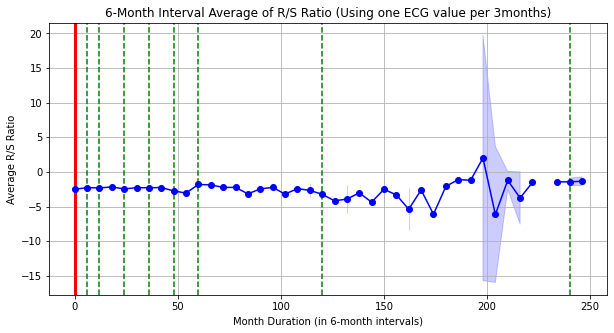

In [200]:
plot_after_ecg(cmp_obj, '3months','R/S Ratio')

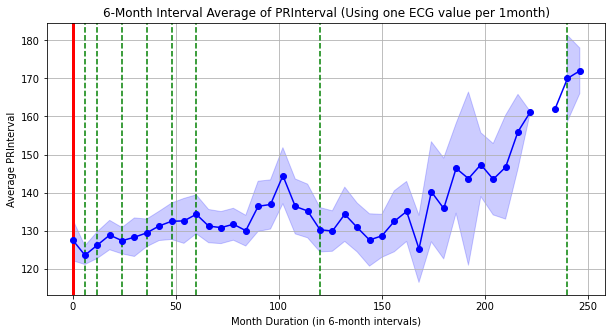

In [90]:
plot_after_ecg(cmp_obj, '1month','PRInterval')

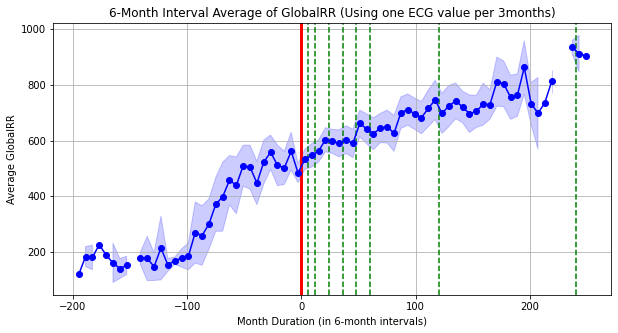

In [223]:
plot_ecg(cmp_obj, '3months','GlobalRR')

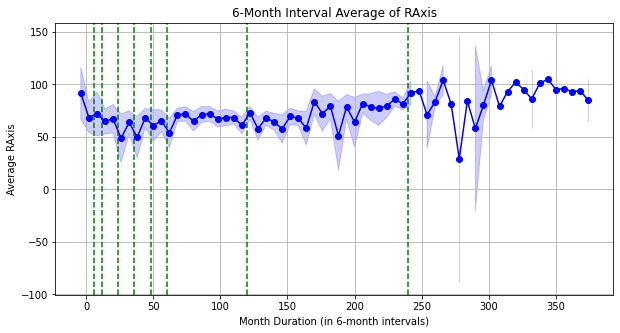

In [245]:
plot_ecg(no_cmp_obj, 'Month Duration','RAxis')

### 나이별

In [452]:
# BirthD를 Timestamp 형식으로 변환
cmp_obj['BirthD'] = pd.to_datetime(cmp_obj['BirthD'])

# 날짜 간 차이를 계산하여 나이를 구함
cmp_obj['Age'] = (cmp_obj['AcquisitionDate'] - cmp_obj['BirthD']).dt.days // 365

# BirthD를 Timestamp 형식으로 변환
no_cmp_obj['BirthD'] = pd.to_datetime(no_cmp_obj['BirthD'])

# 날짜 간 차이를 계산하여 나이를 구함
no_cmp_obj['Age'] = (no_cmp_obj['AcquisitionDate'] - no_cmp_obj['BirthD']).dt.days // 365

/tmp/ipykernel_4565/814205749.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_cmp_obj['BirthD'] = pd.to_datetime(no_cmp_obj['BirthD'])
/tmp/ipykernel_4565/814205749.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_cmp_obj['Age'] = (no_cmp_obj['AcquisitionDate'] - no_cmp_obj['BirthD']).dt.days // 365


In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

def plot_age_comparison(cmp_obj, no_cmp_obj, term, age_col, signal_name):
    def calculate_averages_and_conf_intervals(cmp_obj, age_col, signal_name):
        age_groups = cmp_obj[age_col].unique()
        age_groups.sort()

        averages = []
        conf_intervals = []
        for age in age_groups:
            data = cmp_obj[cmp_obj[age_col] == age][signal_name]
            avg = np.mean(data)
            confidence_interval = sem(data) * 1.96  # 95% 신뢰 구간 계산
            averages.append(avg)
            conf_intervals.append(confidence_interval)

        return age_groups, averages, conf_intervals
    cmp_obj1 = cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
    cmp_obj2 = no_cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
    # 각 데이터프레임에 대해 평균 및 신뢰 구간 계산
    age_groups1, averages1, conf_intervals1 = calculate_averages_and_conf_intervals(cmp_obj1, age_col, signal_name)
    age_groups2, averages2, conf_intervals2 = calculate_averages_and_conf_intervals(cmp_obj2, age_col, signal_name)

    # 시각화
    plt.figure(figsize=(10, 5))

    # 첫 번째 데이터프레임의 그래프
    plt.plot(age_groups1, averages1, marker='o', linestyle='-', color='b', label='cmp')
    plt.fill_between(age_groups1, 
                     np.array(averages1) - np.array(conf_intervals1), 
                     np.array(averages1) + np.array(conf_intervals1), 
                     color='b', alpha=0.2)

    # 두 번째 데이터프레임의 그래프
    plt.plot(age_groups2, averages2, marker='o', linestyle='-', color='r', label='non cmp')
    plt.fill_between(age_groups2, 
                     np.array(averages2) - np.array(conf_intervals2), 
                     np.array(averages2) + np.array(conf_intervals2), 
                     color='r', alpha=0.2)
    if signal_name =='R' or signal_name == 'S':
        plt.xlabel('Age')
        plt.ylabel('Average ' + signal_name+'(mV)')
        plt.title('Comparison of ' + signal_name + ' by Age'+'('+ term + ')')
        plt.legend()
        plt.grid(True)
        plt.show()
    else: 
        plt.xlabel('Age')
        plt.ylabel('Average ' + signal_name)
        plt.title('Comparison of ' + signal_name + ' by Age'+'('+ term + ')')
        plt.legend()
        plt.grid(True)
        plt.show()



/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


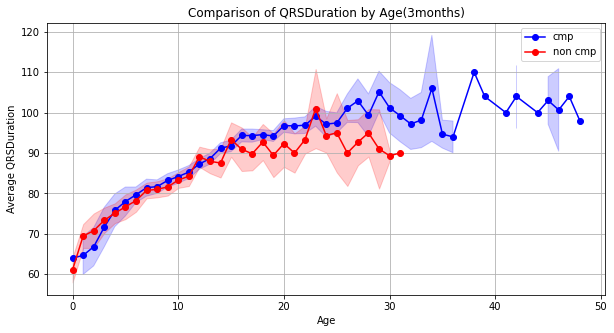

In [126]:
# 사용 예시:
plot_age_comparison(cmp_obj, no_cmp_obj, '3months','Age', 'QRSDuration')

### 나이별 plot 차이 유의성 판별

In [216]:
cmp_obj['R'] = cmp_obj['R'].astype('float')
cmp_obj['S'] = cmp_obj['S'].astype('float')
cmp_obj['R/S Ratio'] = cmp_obj['R/S Ratio'].astype('float')
no_cmp_obj['R'] = no_cmp_obj['R'].astype('float')
no_cmp_obj['S'] = no_cmp_obj['S'].astype('float')
no_cmp_obj['R/S Ratio'] = no_cmp_obj['R/S Ratio'].astype('float')

NameError: name 'cmp_obj' is not defined

In [166]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
def plot_explanation(cmp_obj, no_cmp_obj, term,signal_name):
    
    # def plot_age_comparison(cmp_obj, no_cmp_obj, term, age_col, signal_name):
    def calculate_averages_and_conf_intervals(cmp_obj, age_col, signal_name):
        age_groups = cmp_obj[age_col].unique()
        age_groups.sort()

        averages = []
        conf_intervals = []
        for age in age_groups:
            data = cmp_obj[cmp_obj[age_col] == age][signal_name]
            avg = np.mean(data)
            confidence_interval = sem(data) * 1.96  # 95% 신뢰 구간 계산
            averages.append(avg)
            conf_intervals.append(confidence_interval)

        return age_groups, averages, conf_intervals
    cmp_obj1 = cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
    cmp_obj2 = no_cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
    # 각 데이터프레임에 대해 평균 및 신뢰 구간 계산
    age_groups1, averages1, conf_intervals1 = calculate_averages_and_conf_intervals(cmp_obj, 'Age', signal_name)
    age_groups2, averages2, conf_intervals2 = calculate_averages_and_conf_intervals(no_cmp_obj, 'Age', signal_name)
    

    ### 나이 평균값 별 차이
    group_cmp = averages1
    group_non_cmp = averages2

    # 두 그룹 간의 t-검정
    t_stat, p_value = ttest_ind(group_cmp, group_non_cmp)    
    # Mann-Whitney U Test 수행
    u_stat, u_p_value = mannwhitneyu(averages1, averages2, alternative='two-sided')
    
    print('--나이별 평균값 간 차이 유의성--')
    print(f't-Statistic: {t_stat:.3f}, p-Value: {p_value:.3f}')
    print(f"Mann-Whitney U Statistic: {u_stat:.3f}, p-Value: {u_p_value:.3f}")
    
    
    # 전체 데이터에서 CMP군과 Non-CMP군의 QRSDuration 비교
    cmp_data = cmp_obj1[signal_name].dropna()
    non_cmp_data = cmp_obj2[signal_name].dropna()

    # t-test 수행
    t_stat, t_p_value = ttest_ind(cmp_data, non_cmp_data)

    # Mann-Whitney U Test 수행
    u_stat, u_p_value = mannwhitneyu(cmp_data, non_cmp_data, alternative='two-sided')
    
    print('--전체 군간 차이 유의성--')
    print(f"t-Statistic: {t_stat:.3f}, p-Value: {t_p_value:.3f}")
    print(f"Mann-Whitney U Statistic: {u_stat:.3f}, p-Value: {u_p_value:.3f}")


In [176]:
plot_explanation(cmp_obj, no_cmp_obj, '3months','GlobalRR')

--나이별 평균값 간 차이 유의성--
t-Statistic: 0.331, p-Value: 0.741
Mann-Whitney U Statistic: 867.000, p-Value: 0.185
--전체 군간 차이 유의성--
t-Statistic: 3.838, p-Value: 0.000
Mann-Whitney U Statistic: 1134044.000, p-Value: 0.000


### Cmp 발생 당시 심전도의 모든 파라미터가 같은 나이 다른 환자랑 비교했을 때 - 3살 단위로

In [337]:
cmp_obj['BirthD'] = pd.to_datetime(cmp_obj['BirthD'])
cmp_obj['CMP_date'] = pd.to_datetime(cmp_obj['CMP_date'])

In [338]:
cmp_obj['cmp_age'] = (cmp_obj['CMP_date'] - cmp_obj['BirthD']).dt.days // 365

In [339]:
cmp_obj['cmp_age'].value_counts()

13    514
14    465
12    353
15    335
11    285
16    270
18    212
10    178
17    174
6     156
19    141
24    136
8     103
9      93
21     82
23     57
7      51
22     44
4      32
20     29
5      24
26     15
41     12
29     10
2       8
30      8
31      6
Name: cmp_age, dtype: int64

In [340]:
no_cmp_obj['Age'].value_counts()

13    57
9     57
12    53
8     52
10    51
11    47
7     45
6     37
14    26
3     25
5     23
4     21
1     15
16    15
15    15
18    14
2     13
17    12
0      9
19     7
21     6
24     6
20     6
27     3
30     3
26     3
22     3
23     2
28     2
29     2
25     2
31     1
Name: Age, dtype: int64

/tmp/ipykernel_4565/1992713058.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['Age Group'] = pd.cut(obj[age_col], bins=bins, labels=labels, right=True, include_lowest=True)
/tmp/ipykernel_4565/1992713058.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['Age Group'] = pd.cut(obj[age_col], bins=bins, labels=labels, right=True, include_lowest=True)


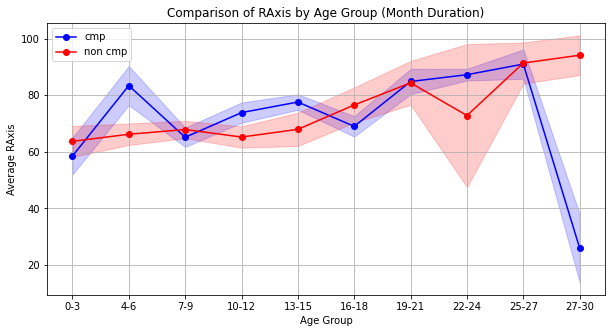

In [254]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

def plot_age_comparison(cmp_obj, no_cmp_obj, term, cmp_age_col, no_cmp_age_col, signal_name, bins, labels):
    def calculate_averages_and_conf_intervals(obj, age_col, signal_name):
        # 나이를 구간으로 그룹화
        obj['Age Group'] = pd.cut(obj[age_col], bins=bins, labels=labels, right=True, include_lowest=True)
        age_groups = obj['Age Group'].cat.categories  # 카테고리 정렬

        averages = []
        conf_intervals = []
        for group in age_groups:
            data = obj[obj['Age Group'] == group][signal_name]
            avg = np.mean(data)
            confidence_interval = sem(data) * 1.96  # 95% 신뢰 구간 계산
            averages.append(avg)
            conf_intervals.append(confidence_interval)

        return age_groups, averages, conf_intervals

    cmp_obj1 = cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
    no_cmp_obj2 = no_cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
    
    # 각 데이터프레임에 대해 평균 및 신뢰 구간 계산
    age_groups1, averages1, conf_intervals1 = calculate_averages_and_conf_intervals(cmp_obj1, cmp_age_col, signal_name)
    age_groups2, averages2, conf_intervals2 = calculate_averages_and_conf_intervals(no_cmp_obj2, no_cmp_age_col, signal_name)

    # 시각화
    plt.figure(figsize=(10, 5))

    # 첫 번째 데이터프레임의 그래프
    plt.plot(age_groups1, averages1, marker='o', linestyle='-', color='b', label='cmp')
    plt.fill_between(age_groups1, 
                     np.array(averages1) - np.array(conf_intervals1), 
                     np.array(averages1) + np.array(conf_intervals1), 
                     color='b', alpha=0.2)

    # 두 번째 데이터프레임의 그래프
    plt.plot(age_groups2, averages2, marker='o', linestyle='-', color='r', label='non cmp')
    plt.fill_between(age_groups2, 
                     np.array(averages2) - np.array(conf_intervals2), 
                     np.array(averages2) + np.array(conf_intervals2), 
                     color='r', alpha=0.2)

    # 그래프에 레이블과 타이틀 추가
    plt.xlabel('Age Group')
    plt.ylabel('Average ' + signal_name + (' (mV)' if signal_name in ['R', 'S'] else ''))
    plt.title('Comparison of ' + signal_name + ' by Age Group' + ' (' + term + ')')
    plt.legend()
    plt.grid(True)
    plt.show()

# 나이 구간과 레이블 정의
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24,27,30]  # 예시로 3살 단위로 구간 설정
labels = ['0-3', '4-6', '7-9', '10-12', '13-15', '16-18', '19-21', '22-24','25-27','27-30']

# 예시로 함수 호출
plot_age_comparison(cmp_obj, no_cmp_obj, 'Month Duration', 'cmp_age', 'Age', 'RAxis', bins, labels)


### 나이별 plotting
- 해당 나이에 non-cmp 또는 cmp인 케이스들 비교

In [1]:
import preprocessing
import pandas as pd
final_data = preprocessing.p()

100%|████████████████████████████████| 4659/4659 [00:06<00:00, 710.68it/s]
/home/kyuheelim_990209/share/CDM_DDMD/preprocessing.py:294: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  person_progress = pd.read_excel('DMD outcome data 240810.xlsx',header=1)[['ID','Death','CMP','HF Hosp','Death or HF Hosp','BirthD','Last_fu_date',
/home/kyuheelim_990209/share/CDM_DDMD/preprocessing.py:301: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  person_progress_2 = pd.read_excel('DMD_outcome_data_ver2.xlsx',header=1)[['ID','person_id']]


In [2]:
import pandas as pd

# 가정: df는 이미 존재하며, PatientID, CMP_date, acquisition_date 컬럼이 있다고 가정합니다.

# CMP_date 및 acquisition_date를 datetime 형식으로 변환 (만약 아직 변환하지 않은 경우)
final_data['CMP_date'] = pd.to_datetime(final_data['CMP_date'])
final_data['AcquisitionDate'] = pd.to_datetime(final_data['AcquisitionDate'])

# 비교하여 새로운 컬럼 생성
final_data['comparison_result'] = final_data.apply(lambda row: 1 if row['AcquisitionDate'] > row['CMP_date'] else 0, axis=1)


In [3]:
final_data['BirthD'] = pd.to_datetime(final_data['BirthD'])
final_data['Age'] = (final_data['AcquisitionDate'] - final_data['BirthD']).dt.days // 365


In [4]:
final_data = final_data[['PatientID','BirthD','Death date','CMP_date','AcquisitionDate','QRSDuration','PAxis', 'RAxis', 'TAxis','QTInterval','Death','CMP',
       'QTCorrected','PRInterval','GlobalRR','comparison_result','Age',
                        'Q_I','R_I', 'S_I', 'R/S Ratio_I',
                        'Q_II','R_II','S_II',
                        'Q_III','R_III','S_III',
                        'Q_V4','R_V4','S_V4',
                        'Q_V5','R_V5','S_V5',
                        'Q_V6','R_V6','S_V6',
                        'Q_aVF','R_aVF','S_aVF',
                        'Q_aVR','R_aVR','S_aVR',
                        'Q_aVL','R_aVL','S_aVL']]
final_data

,PatientID,BirthD,Death date,CMP_date,AcquisitionDate,QRSDuration,PAxis,RAxis,TAxis,QTInterval,...,S_V6,Q_aVF,R_aVF,S_aVF,Q_aVR,R_aVR,S_aVR,Q_aVL,R_aVL,S_aVL
2235,2263640,1997-08-11,NaT,2018-01-11,2004-11-29,72.0,60.0,77.0,46.0,310.0,...,-0.066509,-0.088047,0.268581,-0.031759,-0.043288,0.163332,-0.026178,-0.009001,0.054998,-0.108133
2234,2263640,1997-08-11,NaT,2018-01-11,2004-11-29,72.0,60.0,77.0,46.0,310.0,...,-0.066509,-0.088047,0.268581,-0.031759,-0.043288,0.163332,-0.026178,-0.009001,0.054998,-0.108133
2161,2260375,2001-07-27,NaT,2013-02-01,2004-12-09,56.0,42.0,88.0,34.0,312.0,...,-0.037823,-0.123763,0.365953,-0.024154,-0.034107,0.141419,-0.033699,0.005797,0.099925,-0.226910
2106,2258487,1996-01-30,NaT,2011-01-04,2005-01-05,80.0,60.0,100.0,61.0,324.0,...,-0.109604,-0.036879,0.298735,-0.137886,-0.019817,0.136266,-0.106036,-0.050647,0.046871,-0.135088
1235,2239346,1995-11-26,NaT,2005-01-11,2005-01-11,78.0,66.0,60.0,48.0,298.0,...,-0.090235,-0.055463,0.285668,-0.129068,-0.070229,0.282328,-0.094124,-0.025362,0.027763,0.002307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,3782102,2008-10-27,NaT,2022-06-02,2022-06-02,88.0,21.0,53.0,-6.0,338.0,...,-0.080250,-0.059937,0.349125,-0.067375,-0.049781,0.342125,-0.083906,-0.033125,0.149812,-0.156563
3770,2451959,1996-11-04,2022-10-06,2020-06-30,2022-06-04,84.0,79.0,106.0,51.0,350.0,...,-0.084118,-0.110029,0.246118,-0.043235,-0.067618,0.087265,-0.058765,-0.029735,0.039500,-0.155471
3771,2451959,1996-11-04,2022-10-06,2020-06-30,2022-06-04,80.0,76.0,105.0,52.0,354.0,...,-0.086941,-0.115176,0.237882,-0.048882,-0.066765,0.089824,-0.058676,-0.024294,0.045588,-0.148029
4238,2547595,2004-07-27,NaT,2014-01-15,2022-06-05,88.0,35.0,101.0,-1.0,324.0,...,-0.054353,-0.019500,0.188559,-0.024147,-0.016912,0.153559,-0.109971,-0.026882,-0.009059,-0.179529


In [5]:
len(final_data[final_data['CMP'] == 0].PatientID.unique())

245

In [6]:
final_data['comparison_result'].value_counts()

1    2880
0    1547
Name: comparison_result, dtype: int64

In [7]:
final_data['cmp_age'] = (final_data['CMP_date'] - final_data['BirthD']).dt.days // 365

In [8]:
# 각 검사별로 cmp 발병 후 몇 개월 지난 시점의 검사인지 정의

final_data['AcquisitionDate'] = pd.to_datetime(final_data['AcquisitionDate'])

final_data['BirthD'] = pd.to_datetime(final_data['BirthD'])
month_duration = []
for i in range(len(final_data)):
    month_duration.append((final_data['AcquisitionDate'].iloc[i] - final_data['BirthD'].iloc[i]).days/30)

final_data['Month Duration'] = month_duration


In [9]:
final_data.sort_values(by='Month Duration', ascending=False)

,PatientID,BirthD,Death date,CMP_date,AcquisitionDate,QRSDuration,PAxis,RAxis,TAxis,QTInterval,...,R_aVF,S_aVF,Q_aVR,R_aVR,S_aVR,Q_aVL,R_aVL,S_aVL,cmp_age,Month Duration
0,94378,1950-10-12,NaT,NaT,2011-05-04,104.0,50.0,61.0,53.0,358.0,...,0.067667,-0.022967,-0.020100,0.115867,-0.041300,-0.005767,0.052167,-0.066067,NaN,737.300000
4073,2500531,1974-04-27,NaT,2016-03-11,2022-05-17,98.0,44.0,22.0,25.0,352.0,...,0.071833,-0.010292,-0.034083,0.198917,-0.049125,-0.040708,0.173542,-0.058750,41.0,585.066667
4072,2500531,1974-04-27,NaT,2016-03-11,2021-10-12,104.0,60.0,35.0,37.0,358.0,...,0.077167,-0.017333,-0.031583,0.175000,-0.038083,-0.036167,0.141667,-0.060333,41.0,577.833333
4071,2500531,1974-04-27,NaT,2016-03-11,2021-04-13,110.0,46.0,35.0,23.0,354.0,...,0.109318,0.007273,-0.005227,0.202909,-0.017636,-0.020500,0.146409,-0.069636,41.0,571.766667
4070,2500531,1974-04-27,NaT,2016-03-11,2020-09-15,100.0,35.0,15.0,11.0,348.0,...,0.085750,-0.007333,-0.031125,0.193292,-0.050083,-0.046250,0.190083,-0.067583,41.0,564.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,2378729,2008-09-16,NaT,NaT,2009-03-16,60.0,53.0,72.0,48.0,256.0,...,0.241617,-0.049125,-0.033386,0.225800,-0.097961,-0.012735,0.095440,-0.076517,NaN,6.033333
3529,2422099,2010-01-02,NaT,NaT,2010-06-16,54.0,52.0,86.0,43.0,234.0,...,0.236612,-0.026314,-0.026219,0.163988,-0.086117,-0.008645,0.094278,-0.155934,NaN,5.500000
4518,2654162,2016-06-11,NaT,NaT,2016-08-07,58.0,25.0,79.0,13.0,238.0,...,0.161103,-0.018121,-0.033086,0.110017,-0.027345,-0.013750,0.020393,-0.065071,NaN,1.900000
4465,2616440,2015-08-19,NaT,NaT,2015-09-12,60.0,67.0,104.0,67.0,260.0,...,0.152920,-0.039340,-0.011780,0.081380,-0.107320,-0.004640,0.088340,-0.135420,NaN,0.800000


In [10]:
final_data = final_data[final_data['PatientID'] != 94378]

In [11]:
import pandas as pd
final_data['AcquisitionDate'] = pd.to_datetime(final_data['AcquisitionDate'])
# 6개월 단위의 기간 생성
final_data['6months'] = final_data['AcquisitionDate'].dt.year * 2 + (final_data['AcquisitionDate'].dt.month - 1) // 6

# 3개월 단위의 기간 생성
final_data['3months'] = final_data['AcquisitionDate'].dt.year * 4 + (final_data['AcquisitionDate'].dt.month - 1) // 3

# 1개월 단위의 기간 생성
final_data['1month'] = final_data['AcquisitionDate'].dt.to_period('M')

/home/kyuheelim_990209/share/CDM_DDMD/ipykernel_29983/3877453672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['AcquisitionDate'] = pd.to_datetime(final_data['AcquisitionDate'])
/home/kyuheelim_990209/share/CDM_DDMD/ipykernel_29983/3877453672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['6months'] = final_data['AcquisitionDate'].dt.year * 2 + (final_data['AcquisitionDate'].dt.month - 1) // 6
/home/kyuheelim_990209/share/CDM_DDMD/ipykernel_29983/3877453672.py:7: SettingWith

In [27]:
# 나이 있는 그대로 반영(구간별 반영말고 발병 나이 기준으로 0,1 나눔)
# import pandas as pd

# # CMP_date 및 AcquisitionDate를 datetime 형식으로 변환
# final_data['CMP_date'] = pd.to_datetime(final_data['CMP_date'])
# final_data['AcquisitionDate'] = pd.to_datetime(final_data['AcquisitionDate'])

# # 나이 구간 설정
# bins = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]  # 3살 단위로 구간 설정
# labels = ['0-3', '4-6', '7-9', '10-12', '13-15', '16-18', '19-21', '22-24', '25-27', '28-30']

# # 나이 구간으로 나누기 위해 현재 환자의 나이를 계산합니다.
# final_data['Age_at_Acquisition'] = (final_data['AcquisitionDate'] - final_data['BirthD']).dt.days // 365

# # Age_at_Acquisition을 구간으로 나눔
# final_data['Age_Group'] = pd.cut(final_data['Age_at_Acquisition'], bins=bins, labels=labels, right=True, include_lowest=True)

# # 각 나이 구간의 시작 나이 기준으로 comparison_result를 나눔
# final_data['comparison_result'] = final_data.apply(
#     lambda row: 1 if row['CMP_date'].year <= row['AcquisitionDate'].year else 0,
#     axis=1
# )

# # 누적 분류 기준으로 cmp와 non_cmp 분리
# final_data['cumulative_cmp'] = final_data.groupby('PatientID')['comparison_result'].cummax()


# def plot_age_comparison(final_data, signal_name, bins, labels):
#     def calculate_averages_and_conf_intervals(obj, signal_name):
#         averages = []
#         conf_intervals = []
#         counts = []
        
#         for label in labels:
#             data = obj[obj['Age_Group'] == label][signal_name]
#             avg = np.mean(data)
#             confidence_interval = sem(data) * 1.96 if len(data) > 1 else 0
#             averages.append(avg)
#             conf_intervals.append(confidence_interval)
#             counts.append(len(data))
        
#         return averages, conf_intervals, counts
    
#     # cmp 및 non_cmp 데이터 분리
#     cmp_data = final_data[final_data['cumulative_cmp'] == 1]
#     non_cmp_data = final_data[final_data['cumulative_cmp'] == 0]
    
#     # 평균 및 신뢰 구간 계산
#     cmp_averages, cmp_conf_intervals, cmp_counts = calculate_averages_and_conf_intervals(cmp_data, signal_name)
#     non_cmp_averages, non_cmp_conf_intervals, non_cmp_counts = calculate_averages_and_conf_intervals(non_cmp_data, signal_name)
    
#     # 시각화
#     plt.figure(figsize=(10, 5))

#     # cmp 데이터 그래프
#     plt.plot(labels, cmp_averages, marker='o', linestyle='-', color='b', label='cmp')
#     plt.fill_between(labels, 
#                      np.array(cmp_averages) - np.array(cmp_conf_intervals), 
#                      np.array(cmp_averages) + np.array(cmp_conf_intervals), 
#                      color='b', alpha=0.2)

#     for i, txt in enumerate(cmp_counts):
#         plt.annotate(f'{txt}', (labels[i], cmp_averages[i]), textcoords="offset points", xytext=(0,10), ha='center', color='b')

#     # non_cmp 데이터 그래프
#     plt.plot(labels, non_cmp_averages, marker='o', linestyle='-', color='r', label='non cmp')
#     plt.fill_between(labels, 
#                      np.array(non_cmp_averages) - np.array(non_cmp_conf_intervals), 
#                      np.array(non_cmp_averages) + np.array(non_cmp_conf_intervals), 
#                      color='r', alpha=0.2)

#     for i, txt in enumerate(non_cmp_counts):
#         plt.annotate(f'{txt}', (labels[i], non_cmp_averages[i]), textcoords="offset points", xytext=(0,10), ha='center', color='r')

#     # 그래프 레이블 및 타이틀 추가
#     plt.xlabel('Age Group')
#     plt.ylabel('Average ' + signal_name + (' (mV)' if signal_name in ['R', 'S'] else ''))
#     plt.title('Comparison of ' + signal_name + ' by Age Group')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # 예시로 함수 호출
# plot_age_comparison(final_data, 'RAxis', bins, labels)


In [12]:
final_data['Q_I'] = final_data['R_I'].astype('float')
final_data['R_I'] = final_data['R_I'].astype('float')
final_data['S_I'] = final_data['S_I'].astype('float')
final_data['R/S Ratio_I'] = final_data['R/S Ratio_I'].astype('float')

final_data['Q_II'] = final_data['R_II'].astype('float')
final_data['R_II'] = final_data['R_II'].astype('float')
final_data['S_II'] = final_data['S_II'].astype('float')

final_data['Q_III'] = final_data['R_III'].astype('float')
final_data['R_III'] = final_data['R_III'].astype('float')
final_data['S_III'] = final_data['S_III'].astype('float')

final_data['Q_V4'] = final_data['Q_V4'].astype('float')
final_data['R_V4'] = final_data['R_V4'].astype('float')
final_data['S_V4'] = final_data['S_V4'].astype('float')

final_data['Q_V5'] = final_data['Q_V5'].astype('float')
final_data['R_V5'] = final_data['R_V5'].astype('float')
final_data['S_V5'] = final_data['S_V5'].astype('float')

final_data['Q_V6'] = final_data['Q_V6'].astype('float')
final_data['R_V6'] = final_data['R_V6'].astype('float')
final_data['S_V6'] = final_data['S_V6'].astype('float')


final_data['Q_aVF'] = final_data['Q_aVF'].astype('float')
final_data['R_aVF'] = final_data['R_aVF'].astype('float')
final_data['S_aVF'] = final_data['S_aVF'].astype('float')


final_data['Q_aVR'] = final_data['Q_aVR'].astype('float')
final_data['R_aVR'] = final_data['R_aVR'].astype('float')
final_data['S_aVR'] = final_data['S_aVR'].astype('float')


final_data['Q_aVL'] = final_data['Q_aVL'].astype('float')
final_data['R_aVL'] = final_data['R_aVL'].astype('float')
final_data['S_aVL'] = final_data['S_aVL'].astype('float')

/home/kyuheelim_990209/share/CDM_DDMD/ipykernel_29983/2375821397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Q_I'] = final_data['R_I'].astype('float')
/home/kyuheelim_990209/share/CDM_DDMD/ipykernel_29983/2375821397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['R_I'] = final_data['R_I'].astype('float')
/home/kyuheelim_990209/share/CDM_DDMD/ipykernel_29983/2375821397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [29]:
# 나이 구간 반영 + 숫자도 plot에 적히게
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem
import warnings
warnings.filterwarnings('ignore')

def plot_age_comparison(final_data, term, signal_name, bins, labels):
    # CMP_date 및 AcquisitionDate를 datetime 형식으로 변환
    final_data['CMP_date'] = pd.to_datetime(final_data['CMP_date'])
    final_data['AcquisitionDate'] = pd.to_datetime(final_data['AcquisitionDate'])

    # 나이 구간으로 나누기 위해 현재 환자의 나이를 계산합니다.
    final_data['Age_at_Acquisition'] = (final_data['AcquisitionDate'] - final_data['BirthD']).dt.days // 365

    # Age_at_Acquisition을 구간으로 나눔
    final_data['Age_Group'] = pd.cut(final_data['Age_at_Acquisition'], bins=bins, labels=labels, right=True, include_lowest=True)

    # 각 나이 구간의 시작 나이 기준으로 comparison_result를 나눔
    final_data['comparison_result'] = final_data.apply(
        lambda row: 1 if row['CMP_date'] <= row['AcquisitionDate'] else 0,
        axis=1
    )

    # 누적 분류 기준으로 cmp와 non_cmp 분리
    final_data['cumulative_cmp'] = final_data.groupby('PatientID')['comparison_result'].cummax()

    # term을 기준으로 중복 제거 후 cmp와 non_cmp 분리
    cmp_obj1 = final_data[final_data['cumulative_cmp'] == 1].drop_duplicates(subset=['PatientID', term], keep='first')
    no_cmp_obj2 = final_data[final_data['cumulative_cmp'] == 0].drop_duplicates(subset=['PatientID', term], keep='first')

    def calculate_averages_and_conf_intervals(obj, age_col, signal_name):
        # 나이를 구간으로 그룹화
        obj['Age Group'] = pd.cut(obj[age_col], bins=bins, labels=labels, right=True, include_lowest=True)
        age_groups = obj['Age Group'].cat.categories  # 카테고리 정렬

        averages = []
        conf_intervals = []
        patient_counts = []
        record_counts = []
        for group in age_groups:
            data = obj[obj['Age Group'] == group]
            avg = np.mean(data[signal_name])
            confidence_interval = sem(data[signal_name]) * 1.96 if len(data[signal_name]) > 1 else 0  # 95% 신뢰 구간 계산
            unique_patients = data['PatientID'].nunique()  # 고유한 PatientID의 수 계산 (명수)
            total_records = len(data)  # 해당 구간의 총 데이터 수 계산 (건수)
            averages.append(avg)
            conf_intervals.append(confidence_interval)
            patient_counts.append(unique_patients)  # 각 그룹의 명수 추가
            record_counts.append(total_records)  # 각 그룹의 건수 추가

        return age_groups, averages, conf_intervals, patient_counts, record_counts

    # 각 데이터프레임에 대해 평균, 신뢰 구간 및 명수 계산
    age_groups1, averages1, conf_intervals1, patient_counts1, record_counts1 = calculate_averages_and_conf_intervals(cmp_obj1, 'Age_at_Acquisition', signal_name)
    age_groups2, averages2, conf_intervals2, patient_counts2, record_counts2 = calculate_averages_and_conf_intervals(no_cmp_obj2, 'Age_at_Acquisition', signal_name)

    # 시각화
    plt.figure(figsize=(10, 5))

    # 첫 번째 데이터프레임의 그래프 (cmp_obj1)
    plt.plot(age_groups1, averages1, marker='o', linestyle='-', color='b', label='cmp')
    plt.fill_between(age_groups1, 
                     np.array(averages1) - np.array(conf_intervals1), 
                     np.array(averages1) + np.array(conf_intervals1), 
                     color='b', alpha=0.2)

    # 첫 번째 데이터프레임의 명수(건수) 표시
    for i, (patient_txt, record_txt) in enumerate(zip(patient_counts1, record_counts1)):
        plt.annotate(f'{patient_txt} ({record_txt})', 
                     (age_groups1[i], averages1[i]), 
                     textcoords="offset points", 
                     xytext=(0, 10 + (i % 2) * 15),  # 짝수, 홀수 인덱스에 따라 y축 텍스트 위치 조정
                     ha='center', 
                     color='b')

    # 두 번째 데이터프레임의 그래프 (no_cmp_obj2)
    plt.plot(age_groups2, averages2, marker='o', linestyle='-', color='r', label='non cmp')
    plt.fill_between(age_groups2, 
                     np.array(averages2) - np.array(conf_intervals2), 
                     np.array(averages2) + np.array(conf_intervals2), 
                     color='r', alpha=0.2)

    # 두 번째 데이터프레임의 명수(건수) 표시
    for i, (patient_txt, record_txt) in enumerate(zip(patient_counts2, record_counts2)):
        plt.annotate(f'{patient_txt} ({record_txt})', 
                     (age_groups2[i], averages2[i]), 
                     textcoords="offset points", 
                     xytext=(0, -30 + (i % 2) * 15),  # 짝수, 홀수 인덱스에 따라 y축 텍스트 위치 조정
                     ha='center', 
                     color='r')

    # 그래프에 레이블 및 타이틀 추가
    plt.xlabel('Age Group')
    plt.ylabel('Average ' + signal_name + (' (mV)' if signal_name in ['R', 'S'] else ''))
    plt.title('Comparison of ' + signal_name + ' by Age Group' + ' (' + term + ')')
    plt.legend()
    plt.grid(True)
    plt.show()

# 나이 구간과 레이블 정의
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]  # 예시로 3살 단위로 구간 설정
labels = ['0-3', '4-6', '7-9', '10-12', '13-15', '16-18', '19-21', '22-24', '25-27', '28-30']




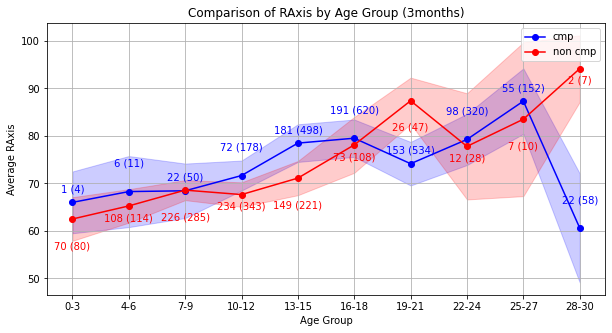

In [260]:
# 함수 호출 예시 (term 반영)
plot_age_comparison(final_data, '3months', 'RAxis', bins, labels)

##### 구간 평균 전체 리스트 p 값

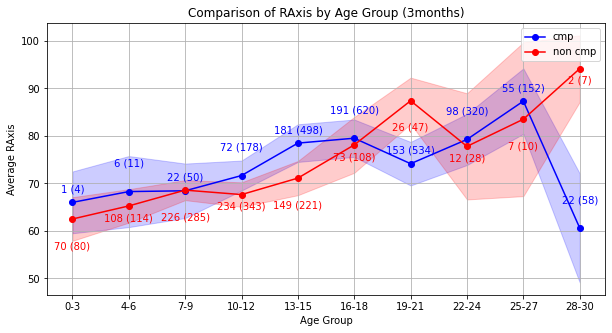

--나이별 평균값 간 차이 유의성--
t-Statistic: -1.737, p-Value: 0.087
Mann-Whitney U Statistic: 642.000, p-Value: 0.344
--전체 군간 차이 유의성--
t-Statistic: 4.867, p-Value: 0.000
Mann-Whitney U Statistic: 1834851.500, p-Value: 0.000


In [268]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

def plot_age_comparison(final_data, term, signal_name, bins, labels):
    # CMP_date 및 AcquisitionDate를 datetime 형식으로 변환
    final_data['CMP_date'] = pd.to_datetime(final_data['CMP_date'])
    final_data['AcquisitionDate'] = pd.to_datetime(final_data['AcquisitionDate'])

    # 나이 구간으로 나누기 위해 현재 환자의 나이를 계산합니다.
    final_data['Age_at_Acquisition'] = (final_data['AcquisitionDate'] - final_data['BirthD']).dt.days // 365

    # Age_at_Acquisition을 구간으로 나눔
    final_data['Age_Group'] = pd.cut(final_data['Age_at_Acquisition'], bins=bins, labels=labels, right=True, include_lowest=True)

    # 각 나이 구간의 시작 나이 기준으로 comparison_result를 나눔
    final_data['comparison_result'] = final_data.apply(
        lambda row: 1 if row['CMP_date'] <= row['AcquisitionDate'] else 0,
        axis=1
    )

    # 누적 분류 기준으로 cmp와 non_cmp 분리
    final_data['cumulative_cmp'] = final_data.groupby('PatientID')['comparison_result'].cummax()

    # term을 기준으로 중복 제거 후 cmp와 non_cmp 분리
    cmp_obj1 = final_data[final_data['cumulative_cmp'] == 1].drop_duplicates(subset=['PatientID', term], keep='first')
    no_cmp_obj2 = final_data[final_data['cumulative_cmp'] == 0].drop_duplicates(subset=['PatientID', term], keep='first')

    def calculate_averages_and_conf_intervals(obj, age_col, signal_name):
        # 나이를 구간으로 그룹화
        obj['Age Group'] = pd.cut(obj[age_col], bins=bins, labels=labels, right=True, include_lowest=True)
        age_groups = obj['Age Group'].cat.categories  # 카테고리 정렬

        averages = []
        conf_intervals = []
        patient_counts = []
        record_counts = []
        for group in age_groups:
            data = obj[obj['Age Group'] == group]
            avg = np.mean(data[signal_name])
            confidence_interval = sem(data[signal_name]) * 1.96 if len(data[signal_name]) > 1 else 0  # 95% 신뢰 구간 계산
            unique_patients = data['PatientID'].nunique()  # 고유한 PatientID의 수 계산 (명수)
            total_records = len(data)  # 해당 구간의 총 데이터 수 계산 (건수)
            averages.append(avg)
            conf_intervals.append(confidence_interval)
            patient_counts.append(unique_patients)  # 각 그룹의 명수 추가
            record_counts.append(total_records)  # 각 그룹의 건수 추가

        return age_groups, averages, conf_intervals, patient_counts, record_counts

    # 각 데이터프레임에 대해 평균, 신뢰 구간 및 명수 계산
    age_groups1, averages1, conf_intervals1, patient_counts1, record_counts1 = calculate_averages_and_conf_intervals(cmp_obj1, 'Age_at_Acquisition', signal_name)
    age_groups2, averages2, conf_intervals2, patient_counts2, record_counts2 = calculate_averages_and_conf_intervals(no_cmp_obj2, 'Age_at_Acquisition', signal_name)

    # 시각화
    plt.figure(figsize=(10, 5))

    # 첫 번째 데이터프레임의 그래프 (cmp_obj1)
    plt.plot(age_groups1, averages1, marker='o', linestyle='-', color='b', label='cmp')
    plt.fill_between(age_groups1, 
                     np.array(averages1) - np.array(conf_intervals1), 
                     np.array(averages1) + np.array(conf_intervals1), 
                     color='b', alpha=0.2)

    # 첫 번째 데이터프레임의 명수(건수) 표시
    for i, (patient_txt, record_txt) in enumerate(zip(patient_counts1, record_counts1)):
        plt.annotate(f'{patient_txt} ({record_txt})', 
                     (age_groups1[i], averages1[i]), 
                     textcoords="offset points", 
                     xytext=(0, 10 + (i % 2) * 15),  # 짝수, 홀수 인덱스에 따라 y축 텍스트 위치 조정
                     ha='center', 
                     color='b')

    # 두 번째 데이터프레임의 그래프 (no_cmp_obj2)
    plt.plot(age_groups2, averages2, marker='o', linestyle='-', color='r', label='non cmp')
    plt.fill_between(age_groups2, 
                     np.array(averages2) - np.array(conf_intervals2), 
                     np.array(averages2) + np.array(conf_intervals2), 
                     color='r', alpha=0.2)

    # 두 번째 데이터프레임의 명수(건수) 표시
    for i, (patient_txt, record_txt) in enumerate(zip(patient_counts2, record_counts2)):
        plt.annotate(f'{patient_txt} ({record_txt})', 
                     (age_groups2[i], averages2[i]), 
                     textcoords="offset points", 
                     xytext=(0, -30 + (i % 2) * 15),  # 짝수, 홀수 인덱스에 따라 y축 텍스트 위치 조정
                     ha='center', 
                     color='r')

    # 그래프에 레이블 및 타이틀 추가
    plt.xlabel('Age Group')
    plt.ylabel('Average ' + signal_name + (' (mV)' if signal_name in ['R', 'S'] else ''))
    plt.title('Comparison of ' + signal_name + ' by Age Group' + ' (' + term + ')')
    plt.legend()
    plt.grid(True)
    plt.show()

    return cmp_obj1, no_cmp_obj2  # 다음 함수에서 사용하기 위해 반환

def plot_explanation(cmp_obj, no_cmp_obj, signal_name):
    def calculate_averages_and_conf_intervals(obj, age_col, signal_name):
        age_groups = obj[age_col].unique()
        age_groups.sort()

        averages = []
        conf_intervals = []
        for age in age_groups:
            data = obj[obj[age_col] == age][signal_name]
            avg = np.mean(data)
            confidence_interval = sem(data) * 1.96 if len(data) > 1 else 0  # 95% 신뢰 구간 계산
            averages.append(avg)
            conf_intervals.append(confidence_interval)

        return age_groups, averages, conf_intervals

    # 각 데이터프레임에 대해 평균 및 신뢰 구간 계산
    age_groups1, averages1, conf_intervals1 = calculate_averages_and_conf_intervals(cmp_obj, 'Age_at_Acquisition', signal_name)
    age_groups2, averages2, conf_intervals2 = calculate_averages_and_conf_intervals(no_cmp_obj, 'Age_at_Acquisition', signal_name)

    # 나이별 평균값 비교
    group_cmp = averages1
    group_non_cmp = averages2

    # 두 그룹 간의 t-검정
    t_stat, p_value = ttest_ind(group_cmp, group_non_cmp)
    # Mann-Whitney U Test 수행
    u_stat, u_p_value = mannwhitneyu(group_cmp, group_non_cmp, alternative='two-sided')

    print('--나이별 평균값 간 차이 유의성--')
    print(f't-Statistic: {t_stat:.3f}, p-Value: {p_value:.3f}')
    print(f"Mann-Whitney U Statistic: {u_stat:.3f}, p-Value: {u_p_value:.3f}")

    # 전체 데이터에서 CMP군과 Non-CMP군의 Signal 비교
    cmp_data = cmp_obj[signal_name].dropna()
    non_cmp_data = no_cmp_obj[signal_name].dropna()

    # t-test 수행
    t_stat, t_p_value = ttest_ind(cmp_data, non_cmp_data)

    # Mann-Whitney U Test 수행
    u_stat, u_p_value = mannwhitneyu(cmp_data, non_cmp_data, alternative='two-sided')

    print('--전체 군간 차이 유의성--')
    print(f"t-Statistic: {t_stat:.3f}, p-Value: {t_p_value:.3f}")
    print(f"Mann-Whitney U Statistic: {u_stat:.3f}, p-Value: {u_p_value:.3f}")

# 나이 구간과 레이블 정의
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]  # 예시로 3살 단위로 구간 설정
labels = ['0-3', '4-6', '7-9', '10-12', '13-15', '16-18', '19-21', '22-24', '25-27', '28-30']
cmp_obj, no_cmp_obj = plot_age_comparison(final_data, '3months', 'RAxis', bins, labels)
plot_explanation(cmp_obj, no_cmp_obj, signal_name)

##### 구간별로 p 값

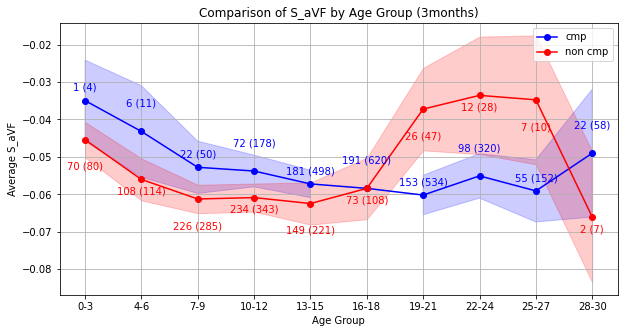

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

def plot_age_comparison(final_data, term, signal_name, bins, labels):
    # CMP_date 및 AcquisitionDate를 datetime 형식으로 변환
    final_data['CMP_date'] = pd.to_datetime(final_data['CMP_date'])
    final_data['AcquisitionDate'] = pd.to_datetime(final_data['AcquisitionDate'])

    # 나이 구간으로 나누기 위해 현재 환자의 나이를 계산합니다.
    final_data['Age_at_Acquisition'] = (final_data['AcquisitionDate'] - final_data['BirthD']).dt.days // 365

    # Age_at_Acquisition을 구간으로 나눔
    final_data['Age_Group'] = pd.cut(final_data['Age_at_Acquisition'], bins=bins, labels=labels, right=True, include_lowest=True)

    # 각 나이 구간의 시작 나이 기준으로 comparison_result를 나눔
    final_data['comparison_result'] = final_data.apply(
        lambda row: 1 if row['CMP_date'] <= row['AcquisitionDate'] else 0,
        axis=1
    )

    # 누적 분류 기준으로 cmp와 non_cmp 분리
    final_data['cumulative_cmp'] = final_data.groupby('PatientID')['comparison_result'].cummax()

    # term을 기준으로 중복 제거 후 cmp와 non_cmp 분리
    cmp_obj1 = final_data[final_data['cumulative_cmp'] == 1].drop_duplicates(subset=['PatientID', term], keep='first')
    no_cmp_obj2 = final_data[final_data['cumulative_cmp'] == 0].drop_duplicates(subset=['PatientID', term], keep='first')

    def calculate_averages_and_conf_intervals(obj, age_col, signal_name):
        # 나이를 구간으로 그룹화
        obj['Age Group'] = pd.cut(obj[age_col], bins=bins, labels=labels, right=True, include_lowest=True)
        age_groups = obj['Age Group'].cat.categories  # 카테고리 정렬

        averages = []
        conf_intervals = []
        patient_counts = []
        record_counts = []
        for group in age_groups:
            data = obj[obj['Age Group'] == group]
            avg = np.mean(data[signal_name])
            confidence_interval = sem(data[signal_name]) * 1.96 if len(data[signal_name]) > 1 else 0  # 95% 신뢰 구간 계산
            unique_patients = data['PatientID'].nunique()  # 고유한 PatientID의 수 계산 (명수)
            total_records = len(data)  # 해당 구간의 총 데이터 수 계산 (건수)
            averages.append(avg)
            conf_intervals.append(confidence_interval)
            patient_counts.append(unique_patients)  # 각 그룹의 명수 추가
            record_counts.append(total_records)  # 각 그룹의 건수 추가

        return age_groups, averages, conf_intervals, patient_counts, record_counts

    # 각 데이터프레임에 대해 평균, 신뢰 구간 및 명수 계산
    age_groups1, averages1, conf_intervals1, patient_counts1, record_counts1 = calculate_averages_and_conf_intervals(cmp_obj1, 'Age_at_Acquisition', signal_name)
    age_groups2, averages2, conf_intervals2, patient_counts2, record_counts2 = calculate_averages_and_conf_intervals(no_cmp_obj2, 'Age_at_Acquisition', signal_name)

    # 시각화
    plt.figure(figsize=(10, 5))

    # 첫 번째 데이터프레임의 그래프 (cmp_obj1)
    plt.plot(age_groups1, averages1, marker='o', linestyle='-', color='b', label='cmp')
    plt.fill_between(age_groups1, 
                     np.array(averages1) - np.array(conf_intervals1), 
                     np.array(averages1) + np.array(conf_intervals1), 
                     color='b', alpha=0.2)

    # 첫 번째 데이터프레임의 명수(건수) 표시
    for i, (patient_txt, record_txt) in enumerate(zip(patient_counts1, record_counts1)):
        plt.annotate(f'{patient_txt} ({record_txt})', 
                     (age_groups1[i], averages1[i]), 
                     textcoords="offset points", 
                     xytext=(0, 10 + (i % 2) * 15),  # 짝수, 홀수 인덱스에 따라 y축 텍스트 위치 조정
                     ha='center', 
                     color='b')

    # 두 번째 데이터프레임의 그래프 (no_cmp_obj2)
    plt.plot(age_groups2, averages2, marker='o', linestyle='-', color='r', label='non cmp')
    plt.fill_between(age_groups2, 
                     np.array(averages2) - np.array(conf_intervals2), 
                     np.array(averages2) + np.array(conf_intervals2), 
                     color='r', alpha=0.2)

    # 두 번째 데이터프레임의 명수(건수) 표시
    for i, (patient_txt, record_txt) in enumerate(zip(patient_counts2, record_counts2)):
        plt.annotate(f'{patient_txt} ({record_txt})', 
                     (age_groups2[i], averages2[i]), 
                     textcoords="offset points", 
                     xytext=(0, -30 + (i % 2) * 15),  # 짝수, 홀수 인덱스에 따라 y축 텍스트 위치 조정
                     ha='center', 
                     color='r')

    # 그래프에 레이블 및 타이틀 추가
    plt.xlabel('Age Group')
    plt.ylabel('Average ' + signal_name + (' (mV)' if signal_name in ['R', 'S'] else ''))
    plt.title('Comparison of ' + signal_name + ' by Age Group' + ' (' + term + ')')
    plt.legend()
    plt.grid(True)
    plt.show()

    return cmp_obj1, no_cmp_obj2  # 다음 함수에서 사용하기 위해 반환

def plot_explanation(cmp_obj, no_cmp_obj, signal_name):
    def calculate_averages_and_conf_intervals(obj, age_col, signal_name):
        age_groups = obj[age_col].unique()
        age_groups.sort()

        averages = []
        conf_intervals = []
        for age in age_groups:
            data = obj[obj[age_col] == age][signal_name]
            avg = np.mean(data)
            confidence_interval = sem(data) * 1.96 if len(data) > 1 else 0  # 95% 신뢰 구간 계산
            averages.append(avg)
            conf_intervals.append(confidence_interval)

        return age_groups, averages, conf_intervals

    # 각 데이터프레임에 대해 평균 및 신뢰 구간 계산
    age_groups1, averages1, conf_intervals1 = calculate_averages_and_conf_intervals(cmp_obj, 'Age_at_Acquisition', signal_name)
    age_groups2, averages2, conf_intervals2 = calculate_averages_and_conf_intervals(no_cmp_obj, 'Age_at_Acquisition', signal_name)

    # 나이별 평균값 비교
    group_cmp = averages1
    group_non_cmp = averages2

    # 두 그룹 간의 t-검정
    t_stat, p_value = ttest_ind(group_cmp, group_non_cmp)
    # Mann-Whitney U Test 수행
    u_stat, u_p_value = mannwhitneyu(group_cmp, group_non_cmp, alternative='two-sided')

    print('--나이별 평균값 간 차이 유의성--')
    print(f't-Statistic: {t_stat:.3f}, p-Value: {p_value:.3f}')
    print(f"Mann-Whitney U Statistic: {u_stat:.3f}, p-Value: {u_p_value:.3f}")

    # 전체 데이터에서 CMP군과 Non-CMP군의 Signal 비교
    cmp_data = cmp_obj[signal_name].dropna()
    non_cmp_data = no_cmp_obj[signal_name].dropna()

    # t-test 수행
    t_stat, t_p_value = ttest_ind(cmp_data, non_cmp_data)

    # Mann-Whitney U Test 수행
    u_stat, u_p_value = mannwhitneyu(cmp_data, non_cmp_data, alternative='two-sided')

    print('--전체 군간 차이 유의성--')
    print(f"t-Statistic: {t_stat:.3f}, p-Value: {t_p_value:.3f}")
    print(f"Mann-Whitney U Statistic: {u_stat:.3f}, p-Value: {u_p_value:.3f}")

def find_significance_start(cmp_obj, no_cmp_obj, signal_name, age_col, bins, labels, alpha=0.05):
    # 나이 구간 정의 및 레이블 설정
    cmp_obj['Age_Group'] = pd.cut(cmp_obj[age_col], bins=bins, labels=labels, right=True, include_lowest=True)
    no_cmp_obj['Age_Group'] = pd.cut(no_cmp_obj[age_col], bins=bins, labels=labels, right=True, include_lowest=True)

    age_groups = cmp_obj['Age_Group'].cat.categories
    valid_group = []
    t_p = []
    u_p = []
    for group in age_groups:
        cmp_data = cmp_obj[cmp_obj['Age_Group'] == group][signal_name]
        non_cmp_data = no_cmp_obj[no_cmp_obj['Age_Group'] == group][signal_name]

        # t-test 수행
        t_stat, t_p_value = ttest_ind(cmp_data.dropna(), non_cmp_data.dropna())

        # Mann-Whitney U Test 수행
        u_stat, u_p_value = mannwhitneyu(cmp_data.dropna(), non_cmp_data.dropna(), alternative='two-sided')

        # print(f"Age Group: {group}")
        # print(f"t-Statistic: {t_stat:.3f}, p-Value: {t_p_value:.3f}")
        # print(f"Mann-Whitney U Statistic: {u_stat:.3f}, p-Value: {u_p_value:.3f}")
        # print("-" * 30)
        t_p.append(t_p_value)
        u_p.append(u_p_value)
        if t_p_value < alpha or u_p_value < alpha:
            valid_group.append(group)

    if len(valid_group) == 0: 
        print("어느 나이 구간에서도 유의한 차이가 나타나지 않았습니다.")
    else:
        print(f"유의한 차이가 나타나는 시점은 나이 구간 {valid_group} 입니다.")
    stat_df = pd.DataFrame({'group':age_groups,'t-p':t_p,'u-p':u_p})
    return stat_df
# 나이 구간과 레이블 정의
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]  # 예시로 3살 단위로 구간 설정
labels = ['0-3', '4-6', '7-9', '10-12', '13-15', '16-18', '19-21', '22-24', '25-27', '28-30']

signal = 'S_aVF'
# 가정: final_data는 이미 로드된 DataFrame이며, 필요한 컬럼들이 존재
cmp_obj1, no_cmp_obj2 = plot_age_comparison(final_data, '3months', signal, bins, labels)
# plot_explanation(cmp_obj1, no_cmp_obj2, signal)


In [70]:
d = find_significance_start(cmp_obj1, no_cmp_obj2, signal, 'Age_at_Acquisition', bins, labels)
d = d.T
d.applymap(lambda x: "{:.3f}".format(x) if isinstance(x, (int, float)) else x)


유의한 차이가 나타나는 시점은 나이 구간 ['10-12', '19-21', '22-24', '28-30'] 입니다.


,0,1,2,3,4,5,6,7,8,9
group,0-3,4-6,7-9,10-12,13-15,16-18,19-21,22-24,25-27,28-30
t-p,0.340,0.176,0.083,0.022,0.123,0.997,0.013,0.042,0.147,0.505
u-p,0.332,0.175,0.110,0.054,0.085,0.534,0.001,0.004,0.139,0.010


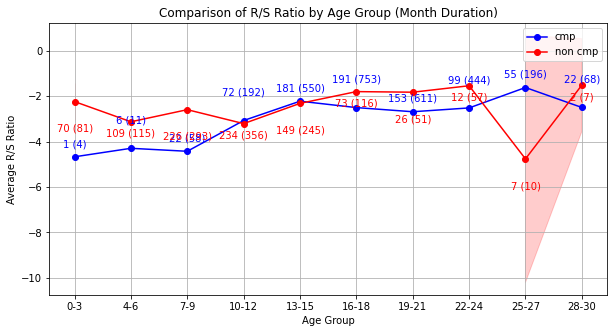

--나이별 평균값 간 차이 유의성--
t-Statistic: nan, p-Value: nan
Mann-Whitney U Statistic: nan, p-Value: nan
--전체 군간 차이 유의성--
t-Statistic: 0.215, p-Value: 0.830
Mann-Whitney U Statistic: 2092439.000, p-Value: 0.000


In [244]:
# 가정: final_data는 이미 로드되어 있음
signal = 'R/S Ratio'
term = 'Month Duration'
cmp_obj, no_cmp_obj = plot_age_comparison(final_data, term, signal, bins, labels)
plot_explanation(cmp_obj, no_cmp_obj, signal)


In [ ]:
# unique_patients = final_data['PatientID'].unique()
# for i in unique_patients:
#     if len(final_data[final_data['PatientID'] == i]['comparison_result'].unique()) != 1:
#         print(i)

### 이상치 확인

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


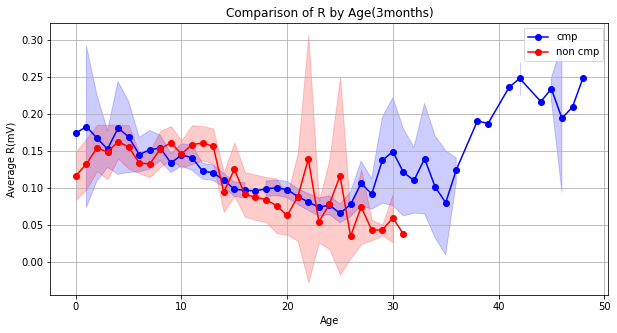

In [142]:
plot_age_comparison(cmp_obj, no_cmp_obj, '3months','Age', 'R')

In [144]:
# def plot_age_comparison(cmp_obj, no_cmp_obj, term, age_col, signal_name):
signal_name = 'R'
age_col = 'Age'
term = '3months'
def calculate_averages_and_conf_intervals(cmp_obj, age_col, signal_name):
    age_groups = cmp_obj[age_col].unique()
    age_groups.sort()

    averages = []
    conf_intervals = []
    for age in age_groups:
        data = cmp_obj[cmp_obj[age_col] == age][signal_name]
        avg = np.mean(data)
        confidence_interval = sem(data) * 1.96  # 95% 신뢰 구간 계산
        averages.append(avg)
        conf_intervals.append(confidence_interval)

    return age_groups, averages, conf_intervals
cmp_obj1 = cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
cmp_obj2 = no_cmp_obj.drop_duplicates(subset=['PatientID', term], keep='first')
# 각 데이터프레임에 대해 평균 및 신뢰 구간 계산
age_groups1, averages1, conf_intervals1 = calculate_averages_and_conf_intervals(cmp_obj1, age_col, signal_name)
age_groups2, averages2, conf_intervals2 = calculate_averages_and_conf_intervals(cmp_obj2, age_col, signal_name)

In [164]:
pd.merge(cmp_obj2[cmp_obj2['Age'] == 25][['PatientID','R','AcquisitionDate']], final_data[['PatientID','ID']], on='PatientID', how = 'left').drop_duplicates()

,PatientID,R,AcquisitionDate,ID
0,2200740,0.048214,2021-03-31,72605633
15,2224321,0.184294,2022-03-10,73421737
